# Импорт библиотек и загрузка данных

Импортирую библиотеки для обработки данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

import warnings
warnings.filterwarnings("ignore")

Считывание файла с данными. Он очень большой!

In [27]:
%%time
df = pd.read_csv(r'C:\Users\Redmi\Downloads\f13_data.csv')

Wall time: 2min 10s


В этом датасете много разных столбцов. Некоторые я до сих пор не понимаю.

In [3]:
df.columns

Index(['Unnamed: 0', 'stamp', 'access_id', 'other_manager',
       'investment_discretion', 'put_call', 'security_class',
       'ssh_prn_amt_type', 'acceptance_stamp', 'market_value', 'ssh_prn_amt',
       'voting_authority_sole', 'voting_authority_shared',
       'voting_authority_none', 'cik', 'conformed_submission_type',
       'conformed_period_of_report', 'filed_as_of_date', 'date_of_change',
       'effectiveness_date', 'fiscal_year_end', 'close', 'is_shifted_price',
       'id'],
      dtype='object')

Подгрузим таблицу соответствия CIK и наименования институционального инвестора. Таблица соответствия взята из базы <a href="https://www.sec.gov/Archives/edgar/cik-lookup-data.txt">EDGAR</a>.

In [4]:
cik_array = []

# Открываю файл
with open('cik-lookup-data.txt', 'r') as cik_data:
    
    # Создаю массив из пар "CIK - Название компании"
    for string in cik_data:
        if string:
            cik_array.append([string[:-13], int(string[-12:-2])])

# Перевожу массив в Dataframe
cik_lookup = pd.DataFrame(data=cik_array, columns=['fund_name', 'cik'])
cik_lookup.head()

,fund_name,cik
0,!J INC,1438823
1,"#1 A LIFESAFER HOLDINGS, INC.",1509607
2,#1 ARIZONA DISCOUNT PROPERTIES LLC,1457512
3,#1 PAINTBALL CORP,1433777
4,$ LLC,1427189


Теперь подгрузим таблицу соответствия тикера и его id. Таблица соответствия взята из базы <a href="https://www.sec.gov/include/ticker.txt">EDGAR</a>. С их помощью я через Yahoo! Finance я попытаюсь вычленить сектор каждой компании-эмитента, чтобы на его основе сгенерировать полезные для анализа переменные.

In [5]:
# Считываю таблицу соответствия
tickers_lookup = pd.read_csv('ticker.txt', sep='\t', names=['ticker', 'ticker_id'])
tickers_lookup.head()

,ticker,ticker_id
0,aapl,320193
1,msft,789019
2,amzn,1018724
3,goog,1652044
4,fb,1326801


Чтобы скачивать данные о секторе, я напишу специальную функцию.

In [6]:
# функция выгрузки секторов для набора тикеров
def extract_tickers_with_sector(symbols: list) -> pd.DataFrame :
    
    from yahooquery import Ticker
    
    # Получаю информацию из базы данных о тикерах
    tickers = Ticker(symbols, asynchronous=True)
    tickers = tickers.get_modules("summaryProfile quoteType")
    tickers = pd.DataFrame.from_dict(tickers).T
    
    # Преобразую информацию в понятный формат
    ticker_frames = [pd.json_normalize([x for x in tickers[module] if isinstance(x, dict)]) \
                                         for module in ['summaryProfile', 'quoteType']]
    
    # Оставляю необходимые столбцы
    tickers = pd.concat(ticker_frames, axis=1)[['symbol', 'sector']]
    # Для будущей пользы (и соответствия исходному формату) изменяю формат тикеров
    tickers.symbol = tickers.symbol.str.lower()

    return tickers

Теперь получу информацию о секторе.

In [7]:
%%time

# Формирую названия тикеров для функции
symbols = tickers_lookup.ticker.unique()
# Получаю значения секторов
tickers = extract_tickers_with_sector(symbols)
# Присоединяю данные о секторе к основной таблице
tickers = tickers.merge(tickers_lookup, left_on='symbol',
                        right_on='ticker', how='right', suffixes=(None, None))
# Удаляю ненужный столбец, по которому велось присоединение
tickers.drop('symbol', axis=1, inplace=True)

tickers.head()

Wall time: 8min 2s


,sector,ticker,ticker_id
0,Technology,aapl,320193
1,Technology,msft,789019
2,Consumer Cyclical,amzn,1018724
3,Communication Services,goog,1652044
4,Communication Services,fb,1326801


Я также заметил, что последняя буква (иногда и две) в написании тикеров часто соответствует типу финансового инструмента. Поэтому для тикеров с ненайденными секторами повторю процедуру, используя их в запросе без первой и второй буквы.

In [8]:
%%time

# Прохожу цикл по количеству убранных с конца букв
for last in (1, 2):
    # Составляю список правильных наименований тикеров без сектора для запроса
    symbols_without_sector = tickers[tickers.sector.isna()].ticker.str[:-last]
    # Получаю таблицу соответствия измененных названий тикеров и сектора
    res_for_symbols_without_sector = extract_tickers_with_sector(symbols_without_sector)
    # Составляю таблицу полных названий тикеров без названия и сектора
    sector_vals = symbols_without_sector.to_frame().merge(res_for_symbols_without_sector, how='left',
                                                          left_on='ticker', right_on='symbol').sector
    # Обновляю изначальную таблицу новыми соответствиями
    tickers.loc[tickers.sector.isna(), 'sector'] = sector_vals.values

# Изменяю пустые поля и отсутствия сектора на неопределенное значение
tickers['sector'] = tickers.sector.replace('', 'Undefined')
tickers['sector'] = tickers.sector.fillna('Undefined')
# Расширяю тип колонки идентификатора тикера для удобства сочленения с основными данными
tickers['ticker_id'] = tickers.ticker_id.astype('int64')

Wall time: 2min 30s


Посмотрим теперь на распределение секторов среди тикеров.

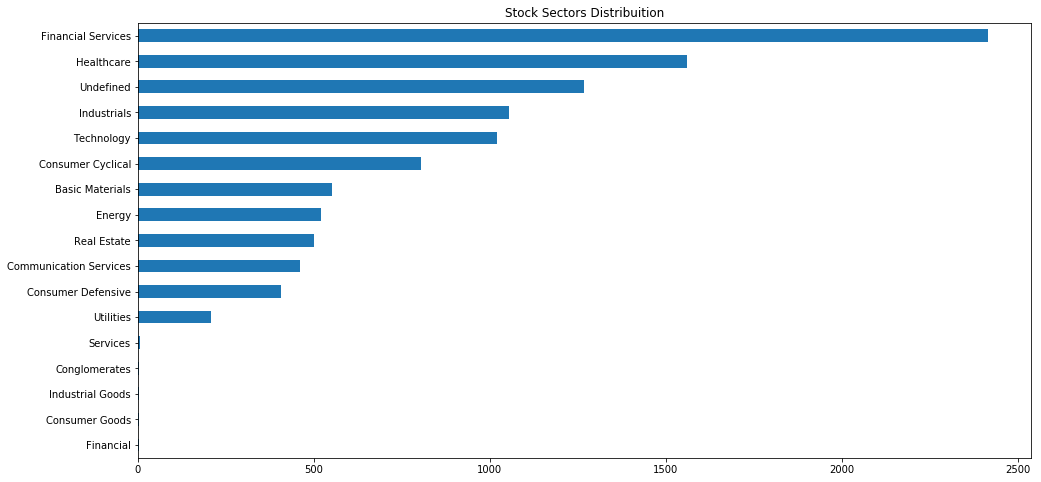

In [9]:
pl.figure(figsize=(16,8));
tickers.sector.value_counts().plot(kind='barh', title='Stock Sectors Distribuition').invert_yaxis();

Большинство компаний работают в секторах Здравоохранения и Финансовых услуг, а также в промышленности, IT и циклических индустрий. Замечу, что у нас огромная доля компаний не получила в соответствие сектор, что не очень приятно для дальнейшего анализа.

# Обработка датасета

Определяю количество лагов доли акции.

In [10]:
num_lags = 4

Чищу данные.

In [28]:
%%time
# оставляю только акции
df = df[df['security_class'] == "STOCK"]
# беру только самодостаточные активы
df = df[df['investment_discretion'] == "SOLE"]
# оставляю только обыкновенные акции с неразделимым правом на голосовании
df = df[(df['voting_authority_sole'] > 0) & (df['voting_authority_shared'] + df['voting_authority_none'] == 0)]

# Создаю переменную количества акций

# Создаю маску, указывающую, где стоит число акций
mask = (df['ssh_prn_amt_type'] == 'SH')
# Нахожу количество акций через отношение стоимости позиции и цены закрытия, если количество не было указано
df['shares'] = mask * df.ssh_prn_amt + (1 - mask) * df.market_value / df.close

# Почему-то в датасете есть позиции, на которых стоит нулевая стоимость или нулевое количество
df = df[df['shares'] > 0]
df = df[df['market_value'] > 0]

# перевожу дату в кварталы
df['period'] = pd.to_datetime(df.conformed_period_of_report).dt.to_period('Q')

# оставляю нужные колонки и перевожу в нужные форматы
df = df[['shares', 'market_value', 'cik', 'period', 'id', 'conformed_submission_type', 'close']].dropna()
df['shares'] = df['shares'].round()
df['ticker_id'] = df['id'].astype('int')
df['cik'] = df['cik'].astype('int')
df.drop('id', axis=1, inplace=True)

Wall time: 47.9 s


Теперь я хочу учесть влияние поправок к основным отчетам. Как сказано в сведениях, в поправках указываются дополнительно купленные к изначальным активы. Значит, моя задача - прибавить эти дополнения к основным показателям.

Для начала я разделю данные на две таблицы по типу отчета.

In [29]:
base_subs = df[df.conformed_submission_type == '13F-HR']
amends = df[df.conformed_submission_type == '13F-HR/A']

Теперь я создам таблицу, где будут находиться данные по позициям, подвергнутым изменениям поправками. Замечу, что часто в этом датасете поправки просто повторяют позиции в основных отчетах, а также дублируются позиции из основных отчетов и поправок, при этом дублируются с противоположным типом отчета. Я скорректирую данные на эти недочеты.

In [30]:
# Выберу позиции, которые могут быть изменены
confront_pos = base_subs.merge(amends, on=['cik', 'period', 'ticker_id'], how='inner', suffixes=(None, '_amend'))
# Отберу позиции, которые не повторяются в поправках
confront_pos = confront_pos[confront_pos.shares != confront_pos.shares_amend]

# Добавлю дополнительно приобретенные акции и их стоимость к основным активам
confront_pos['shares'] += confront_pos['shares_amend']
confront_pos['market_value'] += confront_pos['market_value_amend']

print('Shape with duplicates:', confront_pos.shape)

# Выкину из данных дубликаты
confront_pos.drop_duplicates(inplace=True)

print('Shape without duplicates:', confront_pos.shape)

# Выберу нужные колонки
confront_pos = confront_pos[['shares', 'market_value', 'cik', 'period', 'ticker_id']]

confront_pos.head()

Shape with duplicates: (59224, 11)
Shape without duplicates: (54193, 11)


,shares,market_value,cik,period,ticker_id
32,630349.0,43286000.0,866842,2016Q1,59351
33,2267391.0,72844000.0,866842,2016Q1,55299
34,1223822.0,52497000.0,866842,2016Q1,58022
35,127337.0,2211000.0,866842,2016Q1,13845
36,8244.0,740000.0,866842,2016Q1,10965955


Теперь отражу найденные изменения на основном датасете. Также я создам отдельную переменную, указывающую на то, что позиция притерпела изменения.

In [31]:
# Соединеню оба набора данных
df = base_subs.merge(confront_pos, how='left', on=['cik', 'period', 'ticker_id'], suffixes=(None, '_amend'))

# Перезаполню данные об акциях и их стоимости через измененные значения
df['shares'] = df.shares_amend.fillna(df.shares)
df['market_value'] = df.market_value_amend.fillna(df.market_value)

# Создаю индикатор наличия изменений
df['amend'] = ~df.shares_amend.isna()

# Удаляю ненужные колонки
df.drop(['shares_amend', 'market_value_amend', 'conformed_submission_type'], axis=1, inplace=True)

Теперь постараюсь посмотреть, есть ли смысл использовать сектор компании для анализа вопроса. Посмотрим, какому количеству данных соответствует сектор.

In [32]:
# Привязываю данные о тикерах к основнуму датасету.
data = df.merge(tickers, how='left', on='ticker_id', suffixes=(None, None))

# Вывожу долю покрытия данными о тикерами
print(str(round(data[~data.ticker.isna()].shape[0] / data.shape[0] * 100, 3)) + '% covered by sectoral mapping')

0.39% covered by sectoral mapping


Как мы видим, соответствием в базе тикеров обладает меньше процента наблюдений. Поэтому я не буду включать данные о секторе в разработку модели.

Для красоты отсортирую данные и создам необходимый индекс. 

In [33]:
%%time

# Добавлю индекс комбинации тикера и инвестора для удобства в будущем
df['object'] = df.ticker_id.apply(str) + '_' + df.cik.apply(str)

# Сортирую данные
df = df.sort_values(by=['ticker_id', 'cik', 'period'])

Wall time: 12.2 s


In [34]:
# копирую датасет для возможности бэк-апа
final_df = df.copy(deep=True)

## Размер фондов

Сначала я создаю таблицу накопленной ценности инвестора в каждый квартал.

In [35]:
funds_value = final_df.groupby(by=['period', 'cik'])['market_value'].sum().reset_index()

Формирую пороговые значения низкой и высокой стоимости. Их я выбирал так, чтобы они примерно поровну делили выборку по размеру.

In [36]:
high_value = 3e8
low_value = 1e8

Рассмотрим некоторые основные описательные статистики.

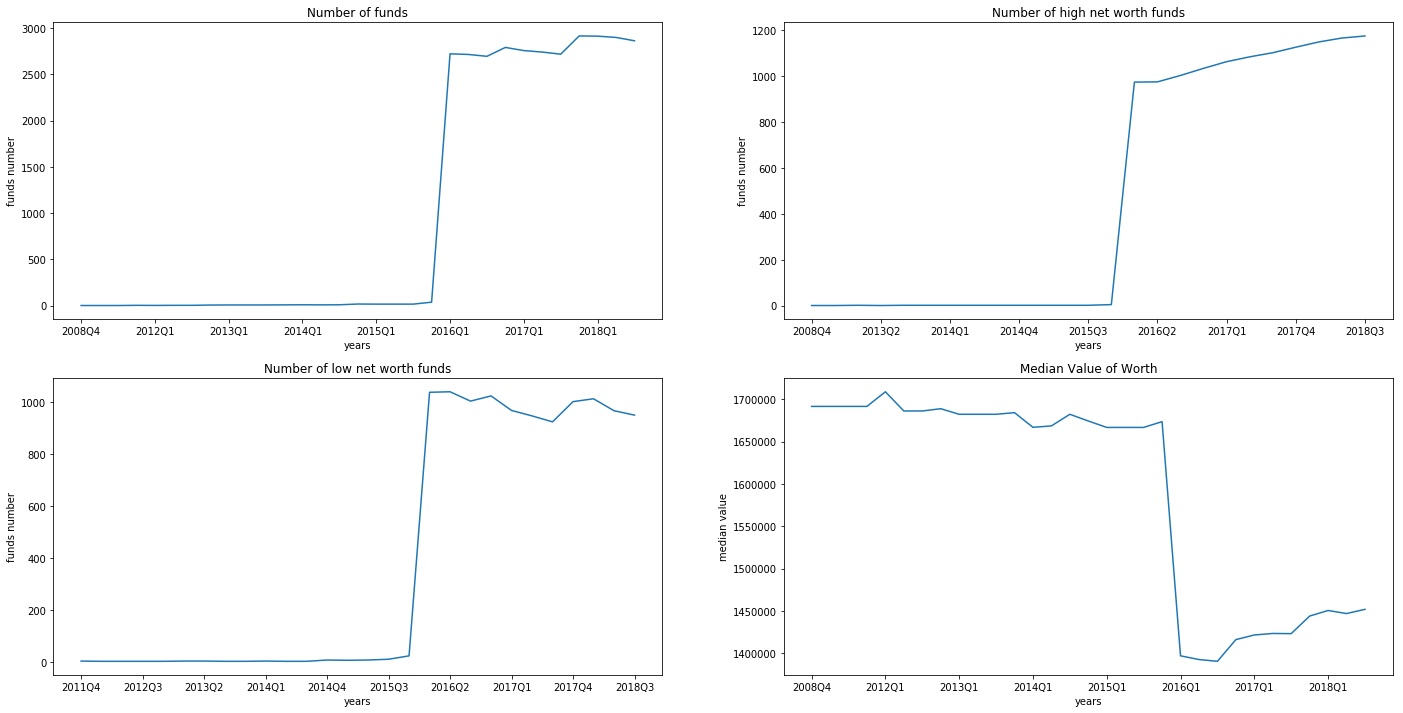

In [37]:
fig, axs = pl.subplots(2, 2, figsize=(24, 12));

plot_data = funds_value.groupby('period')['cik'].nunique()
axs[0, 0].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[0, 0].set_title('Number of funds');
axs[0, 0].set(xlabel='years', ylabel='funds number');
# axs[0, 0].tick_params(axis='x', labelsize=8);
axs[0, 0].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value[funds_value.market_value > high_value].groupby('period')['cik'].nunique()
axs[0, 1].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[0, 1].set_title('Number of high net worth funds');
axs[0, 1].set(xlabel='years', ylabel='funds number');
axs[0, 1].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value[funds_value.market_value < low_value].groupby('period')['cik'].nunique()
axs[1, 0].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[1, 0].set_title('Number of low net worth funds');
axs[1, 0].set(xlabel='years', ylabel='funds number');
axs[1, 0].xaxis.set_major_locator(pl.MaxNLocator(10));

plot_data = funds_value.groupby('period')['cik'].median()
axs[1, 1].plot(plot_data.index.to_series().astype(str), plot_data.values);
axs[1, 1].set_title('Median Value of Worth');
axs[1, 1].set(xlabel='years', ylabel='median value');
axs[1, 1].xaxis.set_major_locator(pl.MaxNLocator(10));

Мы видим, что в нашем датасете до 2017 года фондов почти не было (их было меньше 100). Далее произошло резкое увеличение числа инвесторов, причем значительную их долю составили средние фонды, которые продолжают доминировать по количеству. Замеиим, что медианная стоимость упала в первом квартале 2016-го года, когда бурно увеличилось количество фондов в выборке. Это означает, что большинство пришедших фондов, несмотря на мое деление, были ближе к бедным, чем к богатым. Кроме того, в последнее время количество фондов в выборке уменьшилось. 

Теперь я посмотрю на распределение ценности фондов.

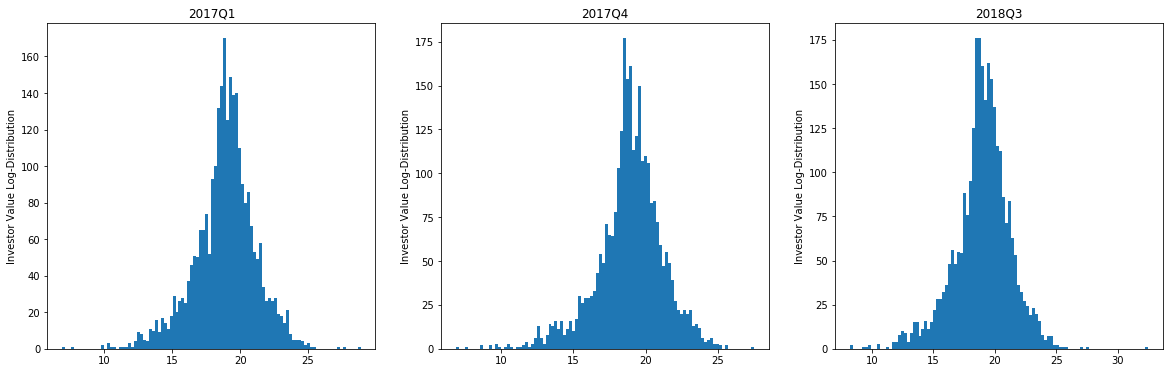

In [38]:
fig, axs = pl.subplots(1, 3, figsize=(20,6));

axs[0].hist(funds_value[funds_value.period == '2017Q1'].market_value.apply(np.log), bins=100);
axs[0].set_title('2017Q1');

axs[1].hist(funds_value[funds_value.period == '2017Q4'].market_value.apply(np.log), bins=100);
axs[1].set_title('2017Q4');

axs[2].hist(funds_value[funds_value.period == '2018Q3'].market_value.apply(np.log), bins=100);
axs[2].set_title('2018Q3');

for ax in axs.flat:
    ax.set(ylabel='Investor Value Log-Distribution')

Из графиков видно, что распределение незначительно изменялось за последние 2 года. Оно похоже на нормальное (то есть, если мы перейдем из логарифма к изначальным значениям, оно будет логнормальным. Только левый хвост у него больше, так как большинство фондов ближе к бедным, как говорилось выше.

Теперь создам дополнительные регрессоры.

In [39]:
final_df = final_df.merge(funds_value, on=['cik', 'period'], how='left', suffixes=('', '_fund'))
# Доля тикера в активах фонда поквартально
final_df['ticket_share'] = final_df.market_value / final_df.market_value_fund
# Логарифмирую ценность фонда как всякую денежную величину
final_df['log_value_fund'] = np.log(final_df.market_value_fund)
# Создаю индикаторные переменные, указывающие на принадлежность фонда к весовой категории
final_df['low_value'] = final_df.market_value_fund.le(low_value)
final_df['high_value'] = final_df.market_value_fund.ge(high_value)
final_df['med_value'] = ~(final_df['low_value'] + final_df['high_value'])

## Создание лагов регрессий

Создаю лаговые значения, связанные с акциями, для каждого наблюдения. Кроме того, создаю основную переменную, представляющую изменение количества акций тикера с начала инвестирования в акцию. Её я и буду предсказывать. Важно уточнить, что изменение считается от первоначально купленного количества акций тикера.

In [40]:
%%time

# Считаю разницу кварталов, чтобы брать только те значения для лагов, которые из предыдущего квартала

# Иначе может выйти так, что я буду создавать лаги на наблюдение, которое было несколько кварталов назад
# Такая ситуация нам не нужна, так как это означает, что фирма тогда закончила инвестирование в эту акцию,
# а потом заново возобновила по другим, возможно, причинам, и начался новый цикл инвестирования в этот тикер
final_df['quarter_diff'] = final_df.period.dt.year * 4 + final_df.period.dt.quarter \
                - (final_df.period.dt.year * 4 + final_df.period.dt.quarter).shift()

# Создаю лаги для количества акций и доли тикера в активах фонда
for lag in range(1, num_lags + 2):
    final_df['shares_lag' + '_' + str(lag)] = final_df.shares.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_diff == 1))
    final_df['ticket_share_lag' + '_' + str(lag)] = final_df.ticket_share.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_diff == 1))
    final_df['amend' + '_' + str(lag)] = final_df.amend.shift(periods=lag). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_diff == 1))

# Создаю лаги первого порядка для переменных размера фондов, так как в прогнозный квартал
# мы не можем наблюдать размер фонда
final_df['market_value_fund_lag' + '_' + str(1)] = final_df.market_value_fund.shift(periods=1). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_diff == 1))    
final_df['log_value_fund_lag' + '_' + str(1)] = final_df.log_value_fund.shift(periods=1). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_diff == 1))
final_df['low_value_lag' + '_' + str(1)] = final_df.low_value.shift(periods=1). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_diff == 1))    
final_df['high_value_lag' + '_' + str(1)] = final_df.high_value.shift(periods=1). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_diff == 1))
final_df['med_value_lag' + '_' + str(1)] = final_df.med_value.shift(periods=1). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_diff == 1))

# Создаю предсказываю переменную и её лаги
for lag in range(1, num_lags + 1):
    final_df['net_shares_lag' + '_' + str(lag)] = final_df['shares_lag' + '_' + str(lag)]. \
                                                  div(final_df['shares_lag' + '_' + str(num_lags + 1)], axis=0).sub(1)

final_df['net_shares'] = final_df.shares.div(final_df['shares_lag' + '_' + str(num_lags + 1)], axis = 0).sub(1)

Wall time: 48.1 s


Вот итоговые переменные.

In [41]:
final_df.head(10)

,shares,market_value,cik,period,close,ticker_id,amend,object,market_value_fund,ticket_share,...,market_value_fund_lag_1,log_value_fund_lag_1,low_value_lag_1,high_value_lag_1,med_value_lag_1,net_shares_lag_1,net_shares_lag_2,net_shares_lag_3,net_shares_lag_4,net_shares
0,30681.0,859000.0,5272,2016Q1,28.000,779,False,779_5272,2.289083e+10,0.000038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29955.0,824062.0,5272,2016Q2,27.510,779,False,779_5272,2.356084e+10,0.000035,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29922.0,862352.0,5272,2016Q3,28.820,779,False,779_5272,2.500677e+10,0.000034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29473.0,974000.0,5272,2016Q4,33.050,779,False,779_5272,2.577238e+10,0.000038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24875.0,879000.0,5272,2017Q1,35.350,779,False,779_5272,2.635926e+10,0.000033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,30773.0,1134000.0,5272,2017Q2,36.850,779,False,779_5272,2.752555e+10,0.000041,...,2.635926e+10,23.995085,False,True,False,-0.189238,-0.039373,-0.024738,-0.023663,0.002999
6,32699.0,1127000.0,5272,2017Q3,34.475,779,False,779_5272,2.809268e+10,0.000040,...,2.752555e+10,24.038381,False,True,False,0.027308,-0.169588,-0.016091,-0.001102,0.091604
7,32818.0,1204000.0,5272,2017Q4,36.700,779,False,779_5272,3.025178e+10,0.000040,...,2.809268e+10,24.058775,False,True,False,0.092808,0.028441,-0.168672,-0.015006,0.096785
8,26489.0,1033000.0,5272,2018Q1,39.000,779,False,779_5272,2.840826e+10,0.000036,...,3.025178e+10,24.132821,False,True,False,0.113494,0.109456,0.044108,-0.156007,-0.101245
9,31682.0,1053000.0,5272,2018Q2,33.250,779,False,779_5272,2.834944e+10,0.000037,...,2.840826e+10,24.069946,False,True,False,0.064884,0.319317,0.314533,0.237106,0.273648


In [42]:
final_df.columns

Index(['shares', 'market_value', 'cik', 'period', 'close', 'ticker_id',
       'amend', 'object', 'market_value_fund', 'ticket_share',
       'log_value_fund', 'low_value', 'high_value', 'med_value',
       'quarter_diff', 'shares_lag_1', 'ticket_share_lag_1', 'amend_1',
       'shares_lag_2', 'ticket_share_lag_2', 'amend_2', 'shares_lag_3',
       'ticket_share_lag_3', 'amend_3', 'shares_lag_4', 'ticket_share_lag_4',
       'amend_4', 'shares_lag_5', 'ticket_share_lag_5', 'amend_5',
       'market_value_fund_lag_1', 'log_value_fund_lag_1', 'low_value_lag_1',
       'high_value_lag_1', 'med_value_lag_1', 'net_shares_lag_1',
       'net_shares_lag_2', 'net_shares_lag_3', 'net_shares_lag_4',
       'net_shares'],
      dtype='object')

## Метрики стиля инвестирования

Сейчас я посмотрю на то, как фонды торгуют через призму стандартных метрик. С помощью этого я постараюсь добавить переменные, которые бы контролировали стиль фонда, ибо в зависимости от стиля инвестирования может меняться отношение к активам.

### Turnover и HHI

Считаю такие классные и потрясающие (реально же) метрики как turnover и индекс Херфиндаля-Хиршмана (HHI) для того, чтобы разграничить фонды по типам инвестирования и проводить контроль по ним. 

Сначала вычислю turnover.

In [43]:
turnover = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.abs(x['ticket_share_lag_1'] - x['ticket_share_lag_2']).sum()).reset_index()
turnover.rename(columns={0: 'turnover'}, inplace=True)
turnover.head()

,period,cik,turnover
0,2008Q4,1691827,0.0
1,2009Q4,1691827,0.0
2,2010Q4,1691827,0.0
3,2011Q4,1686409,0.0
4,2011Q4,1691827,0.0


Теперь HHI.

In [44]:
hhi = final_df.groupby(['period', 'cik']) \
            .apply(lambda x: np.square(x['ticket_share_lag_1']).sum()).reset_index()
hhi.rename(columns={0: 'hhi'}, inplace=True)
hhi.head()

,period,cik,hhi
0,2008Q4,1691827,0.0
1,2009Q4,1691827,0.0
2,2010Q4,1691827,0.0
3,2011Q4,1686409,0.0
4,2011Q4,1691827,0.0


Теперь посмотрю на их распределение.

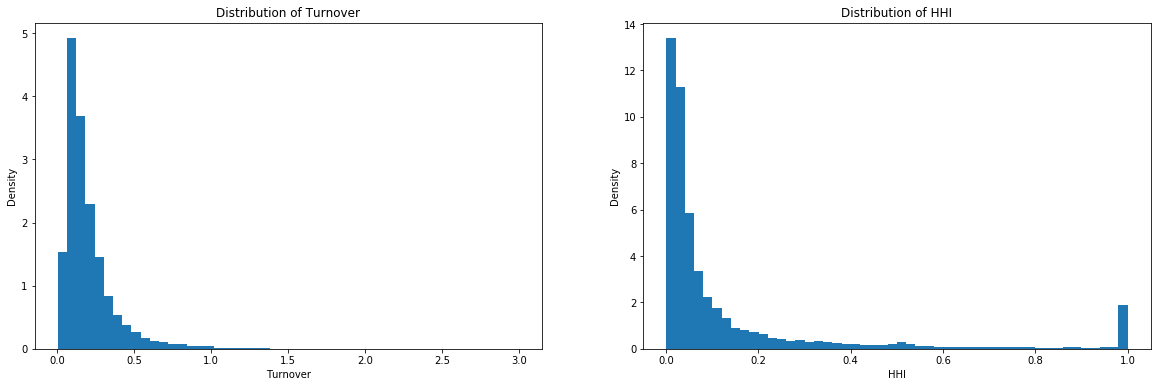

In [45]:
fig, axs = pl.subplots(1, 2, figsize=(20,6));

axs[0].hist(turnover.turnover, density=True, bins=50, range=(0.001, 3));
axs[0].set_title('Distribution of Turnover');
axs[0].set(xlabel='Turnover', ylabel='Density');

axs[1].hist(hhi.hhi, density=True, bins=50, range=(0.001, 1));
axs[1].set_title('Distribution of HHI');
axs[1].set(xlabel='HHI', ylabel='Density');


Можно заметить, что их распределения похожи на геометрическое/Пуассона. Можно разграничить фонды по этим категориям, установив границы для каждого из критерия. Например, 0.5 для Turnover и 0.2 для HHI.

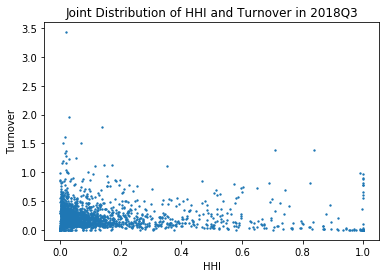

In [46]:
pl.scatter(hhi[hhi.period == final_df.period.max()].hhi, turnover[turnover.period == final_df.period.max()].turnover, s=1.8);
pl.xlabel('HHI');
pl.ylabel('Turnover');
pl.title('Joint Distribution of HHI and Turnover in ' + str(final_df.period.max()));

Если мы посмотрим на совместное их распределение, то не увидим каких-то кластеров. Но подозрительно выделяются наблюдения с HHI=1 (фонды с одной акцией). Вопрос - как такие фонды существуют/как они попали к нам в выборку? Установим контроль и на них.

Добавляю переменные на основе наблюдений.

In [47]:
# Добавляю сами индексы
final_df = final_df.merge(turnover, on=['cik', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(hhi, on=['cik', 'period'], how='left', suffixes=(False, False))

# Устанавливаю контроль на фонды с одной акцией
final_df['hhi_eq_1'] = final_df.hhi.eq(1)

# Разграничиваю фонды по метрикам через индикаторы
final_df['high_hhi'] = final_df.hhi > .2
final_df['high_turnover'] = final_df.turnover > .5

Если мы посмотрим на совместное распределение Размера фонда и наших метрик, то опять не увидим каких-либо кластеров, по которым можно было бы провести классификацию. Печаль.

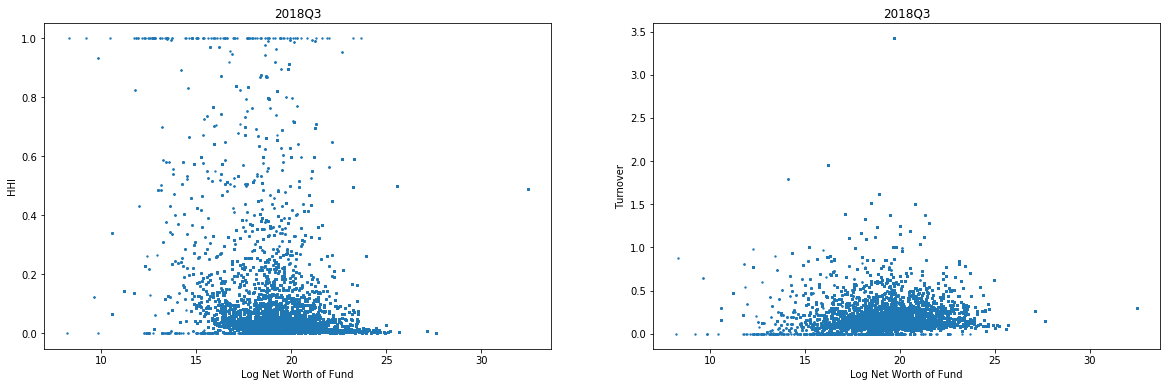

In [48]:
fig, axs = pl.subplots(1, 2, figsize=(20,6));

axs[0].scatter(final_df[final_df.period == final_df.period.max()].log_value_fund,
           final_df[final_df.period == final_df.period.max()].hhi, s=1.8);
axs[0].set_title(final_df.period.max());
axs[0].set(xlabel='Log Net Worth of Fund', ylabel='HHI');

axs[1].scatter(final_df[final_df.period == final_df.period.max()].log_value_fund,
           final_df[final_df.period == final_df.period.max()].turnover, s=1.8);
axs[1].set_title(final_df.period.max());
axs[1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover');

Тем не менее, при достаточной фантазии мы можем представить, что большинство значений находится в окружности с центром в точке (20, 0) и с радиусами 0.4 для HHI и 1.2 для Turnover. Также осуществим контроль на экстремальные значения turnover > 1.4. Они выбиваются из общей картины.

In [49]:
final_df['extreme_turnover'] = final_df.turnover > 1.4
final_df['cluster_hhi'] = (np.square(final_df.hhi) + np.square(final_df.log_value_fund - 20) > (0.4 ** 2))
final_df['cluster_turnover'] = (np.square(final_df.turnover) + np.square(final_df.log_value_fund - 20) > (1.2 ** 2))

Посмотрим на это же совместное распределение, только в разрезе весовой категории фондов.

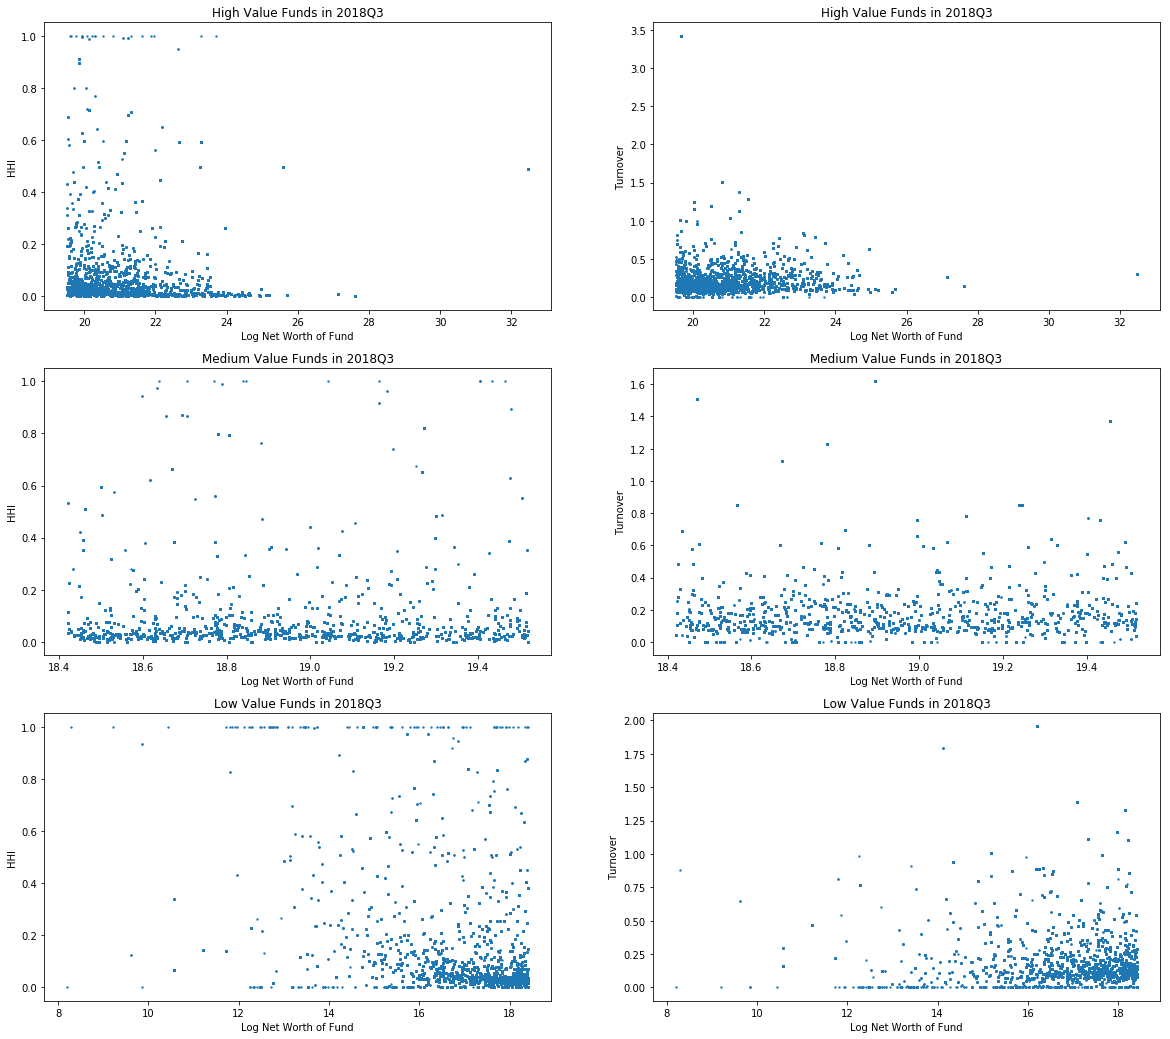

In [50]:
fig, axs = pl.subplots(3, 2, figsize=(20,18));

plot_data_high = final_df[final_df.high_value == True]

axs[0, 0].scatter(plot_data_high[plot_data_high.period == plot_data_high.period.max()].log_value_fund,
           plot_data_high[plot_data_high.period == plot_data_high.period.max()].hhi, s=1.8);
axs[0, 0].set_title('High Value Funds in ' + str(plot_data_high.period.max()));
axs[0, 0].set(xlabel='Log Net Worth of Fund', ylabel='HHI');

axs[0, 1].scatter(plot_data_high[plot_data_high.period == plot_data_high.period.max()].log_value_fund,
           plot_data_high[plot_data_high.period == plot_data_high.period.max()].turnover, s=1.8);
axs[0, 1].set_title('High Value Funds in ' + str(plot_data_high.period.max()));
axs[0, 1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover');

plot_data_med = final_df[final_df.med_value == True]

axs[1, 0].scatter(plot_data_med[plot_data_med.period == plot_data_med.period.max()].log_value_fund,
           plot_data_med[plot_data_med.period == plot_data_med.period.max()].hhi, s=1.8);
axs[1, 0].set_title('Medium Value Funds in ' + str(plot_data_med.period.max()));
axs[1, 0].set(xlabel='Log Net Worth of Fund', ylabel='HHI');

axs[1, 1].scatter(plot_data_med[plot_data_med.period == plot_data_med.period.max()].log_value_fund,
           plot_data_med[plot_data_med.period == plot_data_med.period.max()].turnover, s=1.8);
axs[1, 1].set_title('Medium Value Funds in ' + str(plot_data_med.period.max()));
axs[1, 1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover');

plot_data_low = final_df[final_df.low_value == True]

axs[2, 0].scatter(plot_data_low[plot_data_low.period == plot_data_low.period.max()].log_value_fund,
           plot_data_low[plot_data_low.period == plot_data_low.period.max()].hhi, s=1.8);
axs[2, 0].set_title('Low Value Funds in ' + str(plot_data_low.period.max()));
axs[2, 0].set(xlabel='Log Net Worth of Fund', ylabel='HHI');

axs[2, 1].scatter(plot_data_low[plot_data_low.period == plot_data_low.period.max()].log_value_fund,
           plot_data_low[plot_data_low.period == plot_data_low.period.max()].turnover, s=1.8);
axs[2, 1].set_title('Low Value Funds in ' + str(plot_data_low.period.max()));
axs[2, 1].set(xlabel='Log Net Worth of Fund', ylabel='Turnover');

Как видно из графиков, в разрезе размера стили инвестирования различаются. Чем больше фонд, чем меньше будет HHI, что говорит о высокой диверсификации их активов, что логично, ведь у них достаточно активов для этого. Про turnover можно сказать так же, но только зависимость уже видна слабее. Тем не менее, стоит факторизировать hhi/turnover и размер фонда.

### Количество акций в портфеле

Сейчас я посмотрю на то, как соотносится количество акций в портфеле с его размером и метриками, расмотренными выше.

Сначала я создам таблицу с данными о количестве позиций у фондов.

In [51]:
# Создаю таблицу количества позиций из агрегированных данных
pos_count = final_df.groupby(['period', 'cik']).count().reset_index()[['period', 'cik', 'shares']]
pos_count.rename(columns={'shares': 'pos_count'}, inplace=True)

pos_count.head()

,period,cik,pos_count
0,2008Q4,1691827,119
1,2009Q4,1691827,115
2,2010Q4,1691827,86
3,2011Q4,1686409,4
4,2011Q4,1691827,79


Теперь добавляю эти данные в датасет и пролаггирую их, так как, опять же, нам не доступны данные из периода предсказания.

In [52]:
# Присоединяю новые данные
final_df = final_df.merge(pos_count, on=['period', 'cik'], how='left', suffixes=(False, False))
# Создаю лаг количества тикеров в фонде
final_df['pos_count_lag' + '_' + str(1)] = final_df.pos_count.shift(periods=1). \
                                              where((final_df.object == final_df.object.shift(periods=lag)) &
                                                    (final_df.quarter_diff == 1))

Теперь посмотрим на распределение количества позиций в фонде.

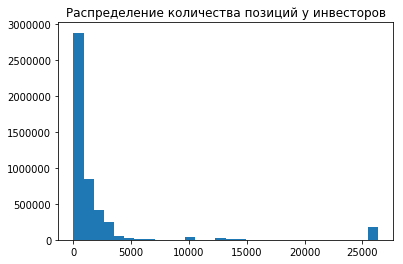

In [53]:
pl.hist(final_df.pos_count, bins=30);
pl.title('Распределение количества позиций у инвесторов');

Как мы видим, есть три кластера: с убывающим распределением от 0 до 5000 позиций, небольшая группа от 10000 до 15000 позиций и маленький островок с 25000 позициями (!!!). Создам индикаторные переменные на принадлежность кластерам.

In [54]:
final_df['high_pos_count'] = final_df.pos_count_lag_1 > 7500
final_df['extreme_pos_count'] = final_df.pos_count_lag_1 > 15000

Теперь возьму корень из количества соседей, чтобы сгладить распределение этой величины.

In [56]:
final_df['sqrt_pos_count_lag_1'] = np.sqrt(final_df.pos_count_lag_1)

Теперь я посмотрю на совместное распределение корня числа позиций и логарифма ценности фонда.

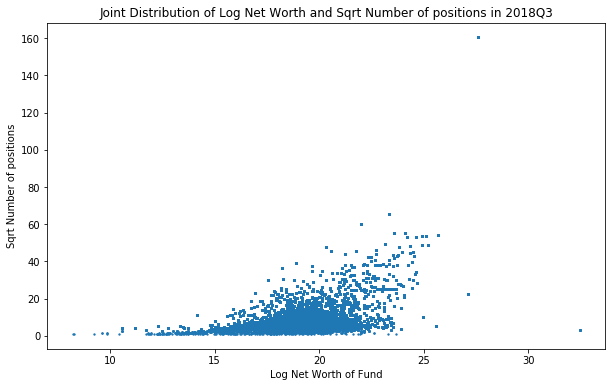

In [61]:
fig, axs = pl.subplots(1, 1, figsize=(10,6));

axs.scatter(final_df[final_df.period == final_df.period.max()].log_value_fund,
           np.sqrt(final_df[final_df.period == final_df.period.max()].pos_count), s=1.8);
axs.set_title('Joint Distribution of Log Net Worth and Sqrt Number of positions in ' + str(final_df.period.max()));
axs.set(xlabel='Log Net Worth of Fund', ylabel='Sqrt Number of positions');

Здесь сложно выделить кластеры, но я предположу, что можно разделить наблюдения на две части по прямой, которая отсечет участок наблюдений с высокой плотностью в нижней части графика от участка с низкой плотностью в верхне.

In [59]:
final_df['cluster_size_pos'] = (np.sqrt(final_df.pos_count_lag_1) > 100 - 4 * final_df.log_value_fund)

Теперь я посмотрю на распределения корня числа позиций относительно HHI и Turnover.

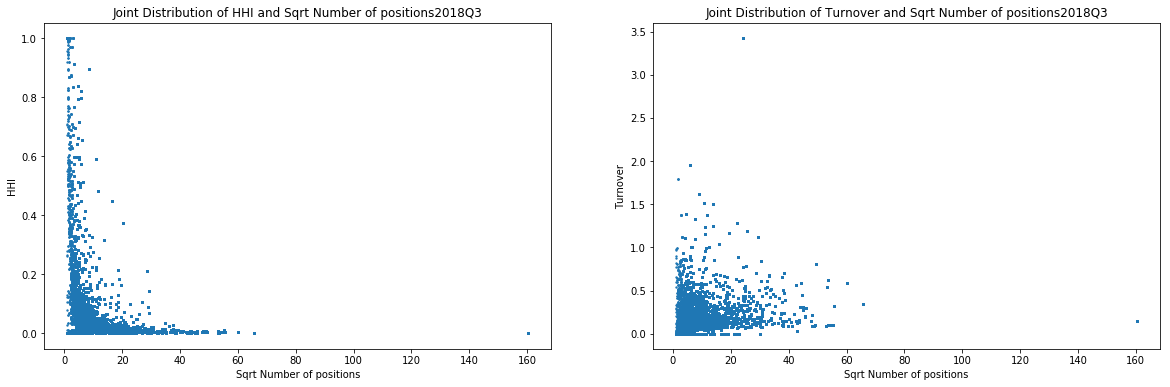

In [62]:
fig, axs = pl.subplots(1, 2, figsize=(20,6));

axs[0].scatter(np.sqrt(final_df[final_df.period == final_df.period.max()].pos_count),
           final_df[final_df.period == final_df.period.max()].hhi, s=1.8);
axs[0].set_title('Joint Distribution of HHI and Sqrt Number of positions' + str(final_df.period.max()));
axs[0].set(xlabel='Sqrt Number of positions', ylabel='HHI');

axs[1].scatter(np.sqrt(final_df[final_df.period == final_df.period.max()].pos_count),
           final_df[final_df.period == final_df.period.max()].turnover, s=1.8);
axs[1].set_title('Joint Distribution of Turnover and Sqrt Number of positions' + str(final_df.period.max()));
axs[1].set(xlabel='Sqrt Number of positions', ylabel='Turnover');

Можно заметить, что большинство значений на первом графике лежат ниже некоторой границы гиперболического вида, а на втором - ниже некоторой линейной границы. Я приблизительно их определю и добавлю на индикаторы на превышение этих границ.

In [63]:
final_df['cluster_pos_hhi'] = (final_df.hhi > 2 / final_df.pos_count_lag_1)
final_df['cluster_pos_tvr'] = (final_df.turnover > 1 - final_df.pos_count_lag_1 / 50)

После всех приготовлений избавлюсь от ненужных наблюдений и столбцов.

In [68]:
# Избавляюсь от ненужных колонок и наблюдений
final_df.drop(['shares_lag_5', 'ticket_share_lag_5', 'quarter_diff',
              'amend_5', 'amend', 'market_value_fund', 'ticket_share',
              'log_value_fund', 'pos_count'], axis=1, inplace=True)
final_df.dropna(inplace=True)

## Variables Factoring

Теперь я факторизирую (<a href="https://www.stata.com/manuals13/u25.pdf">Variable Factoring</a>, не знаю, как лучше перевести, кросс-перемножу) некоторые непрерывные переменные и весовую категорию фонда по ценности, так как я считаю, что в зависимости от категории будет меняться зависимость от данных регрессоров.

In [65]:
%%time

# Для начала я факторизирую переменные, связанные с долей акций и их количеством, и их лаги
for lag in range(1, num_lags + 1):
    final_df['net_shares_lag' + '_' + str(lag) + '_high'] = final_df['net_shares_lag' + '_' + str(lag)] \
                                                    .mul(final_df.high_value, axis=0)
    final_df['net_shares_lag' + '_' + str(lag) + '_med'] = final_df['net_shares_lag' + '_' + str(lag)] \
                                                    .mul(final_df.med_value, axis=0)
    final_df['net_shares_lag' + '_' + str(lag) + '_low'] = final_df['net_shares_lag' + '_' + str(lag)] \
                                                    .mul(final_df.low_value, axis=0)
    
    final_df['ticket_share_lag' + '_' + str(lag) + '_high'] = final_df['net_shares_lag' + '_' + str(lag)] \
                                                    .mul(final_df.high_value, axis=0)
    final_df['ticket_share_lag' + '_' + str(lag) + '_med'] = final_df['net_shares_lag' + '_' + str(lag)] \
                                                    .mul(final_df.med_value, axis=0)
    final_df['ticket_share_lag' + '_' + str(lag) + '_low'] = final_df['net_shares_lag' + '_' + str(lag)] \
                                                    .mul(final_df.low_value, axis=0)

# Затем я факторизирую turnover и HHI
final_df['turnover' + '_high'] = final_df['turnover'].mul(final_df.high_value, axis=0)
final_df['turnover' + '_med'] = final_df['turnover'].mul(final_df.med_value, axis=0)
final_df['turnover' + '_low'] = final_df['turnover'].mul(final_df.low_value, axis=0)

final_df['hhi' + '_high'] = final_df['turnover'].mul(final_df.high_value, axis=0)
final_df['hhi' + '_med'] = final_df['turnover'].mul(final_df.med_value, axis=0)
final_df['hhi' + '_low'] = final_df['turnover'].mul(final_df.low_value, axis=0)

Wall time: 435 ms


Также я добавлю переменную среднего значения изменения позиции тикера по всем фондам и по фондам одной весовой категории, чтобы учесть, как рынок (инвесторы) и сходие по размеру фонды в целом реагировали на ситуацию.

In [66]:
%%time

# Составляю таблицы средних изменений позиций по тикеру и периоду

mean_net_shares = final_df.groupby(['ticker_id', 'period'])['net_shares_lag_1'].mean().reset_index()
mean_net_shares.rename(columns={'net_shares_lag_1': 'mean_net_shares_lag_1'}, inplace=True)


mean_net_shares_by_value = final_df.groupby(['ticker_id', 'period', 'high_value', 'med_value']) \
                                                        ['net_shares_lag_1'].mean().reset_index()
mean_net_shares_by_value.rename(columns={'net_shares_lag_1': 'mean_net_shares_lag_1_by_value'}, inplace=True)

# Сцепляю их с нашим датасетом

final_df = final_df.merge(mean_net_shares, on=['ticker_id', 'period'], how='left', suffixes=(False, False))
final_df = final_df.merge(mean_net_shares_by_value, on=['ticker_id', 'period', 'high_value', 'med_value'],
                                                                  how='left', suffixes=(False, False))

# Считаю количество фондов, владеющих тикером в каждом периоде, чтобы вычесть потом долю отдельного фонда в среднем по тикеру

tickers_count = final_df.groupby(['ticker_id', 'period']).count().reset_index()
tickers_count_by_value = final_df.groupby(['ticker_id', 'period', 'high_value', 'med_value'])\
                                                            .count().reset_index()

tickers_count.rename(columns={'shares': 'tickers_count'}, inplace=True)
tickers_count_by_value.rename(columns={'shares': 'tickers_count_by_value'}, inplace=True)

final_df = final_df.merge(tickers_count[['ticker_id', 'period', 'tickers_count']], on=['ticker_id', 'period'],
                                                                                          how='left', suffixes=(False, False))
final_df = final_df.merge(tickers_count_by_value[['ticker_id', 'period', 'high_value', 'med_value', 'tickers_count_by_value']], 
                                                                        on=['ticker_id', 'period', 'high_value', 'med_value'],
                                                                                          how='left', suffixes=(False, False))

# Вычитаю из среднего по тикеру составляющую конкретного фонда в нем для каждого наблюдения
# Тем самым, я получаю среднее по всем остальным фондам

final_df['mean_net_shares_lag_1'] -= final_df.net_shares_lag_1.div(final_df.tickers_count, axis=0).values
final_df['mean_net_shares_lag_1_by_value'] -= final_df.net_shares_lag_1.div(final_df.tickers_count_by_value, axis=0).values

Wall time: 22.9 s


# Совершаем простейшие регрессии (через МНК)

Теперь, когда я определился с переменными, попробую определить характер зависимости чистого изменения позиции от регрессоров. Для красоты представления буду пользоваться библиотекой <i>statsmodels<i/>. Начну с простой модели без факторизации.

### Модель 1

In [69]:
import statsmodels.api as sm

In [70]:
y = final_df['net_shares']

X = final_df[['log_value_fund_lag_1',
        'net_shares_lag_1', 'amend_1', 'net_shares_lag_2', 'amend_2', 
        'net_shares_lag_3', 'amend_3', 'net_shares_lag_4', 'amend_4',
        'turnover', 'hhi', 'hhi_eq_1', 'high_turnover', 'high_hhi', 
        'extreme_turnover', 'cluster_hhi', 'cluster_turnover',
        'sqrt_pos_count_lag_1', 'high_pos_count', 'extreme_pos_count',
        'cluster_size_pos', 'cluster_pos_hhi', 'cluster_pos_tvr', 'mean_net_shares_lag_1']].astype('float64')
X = sm.add_constant(X)

В этой модели я учитываю величину активов фонда, лаги чистых изменений позиций, переменные, связанные с turnover и hhi, и среднее по остальным фондам.

Делаю первую модель. Простой метод наименьших квадратов.

In [71]:
model_1 = sm.OLS(y, X).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     6440.
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        00:07:59   Log-Likelihood:            -1.0451e+07
No. Observations:             1344781   AIC:                         2.090e+07
Df Residuals:                 1344756   BIC:                         2.090e+07
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.9677      7.792      1.536      0.125      -3.304      27.239
log_value_fund_lag_1     -1.2019      0.377     -3.187      0.001      -1.941      -0.463
net_shares_lag_1          0.0414      0.001     76.291      0.000       0.040       0.042
amend_1                  -3.4111      5.515     -0.619      0.536     -14.219       7.397
net_shares_lag_2          0.6199      0.002    341.412      0.000       0.616       0.623
amend_2                  -5.3904      5.800     -0.929      0.353     -16.758       5.978
net_shares_lag_3          0.0174      0.001     11.986      0.000       0.015       0.020
amend_3                  -2.6579      5.574     -0.477      0.633     -13.583       8.267
net_shares_lag_4          0.0251      0.002     16.341      0.000       0.022       0.028
amend_4                  -3.2298      5.250     -0.615      0.538     -13.519       7.059
turnover                 32.8408      4.585      7.162      0.000      23.854      41.828
hhi                      96.3325     18.978      5.076      0.000      59.137     133.528
hhi_eq_1                -60.2538     36.968     -1.630      0.103    -132.709      12.202
high_turnover             5.2955      2.905      1.823      0.068      -0.398      10.989
high_hhi                -28.9707      7.335     -3.950      0.000     -43.346     -14.595
extreme_turnover       -101.5971     16.110     -6.306      0.000    -133.173     -70.022
cluster_hhi              -3.1030      1.874     -1.655      0.098      -6.777       0.571
cluster_turnover          0.9536      1.366      0.698      0.485      -1.724       3.631
sqrt_pos_count_lag_1      0.2658      0.058      4.559      0.000       0.152       0.380
high_pos_count           -8.5463      7.599     -1.125      0.261     -23.440       6.348
extreme_pos_count         6.6680      8.403      0.794      0.427      -9.801      23.137
cluster_size_pos          0.1652      1.821      0.091      0.928      -3.404       3.735
cluster_pos_hhi          -0.5327      1.608     -0.331      0.740      -3.685       2.619
cluster_pos_tvr           3.8618      2.927      1.319      0.187      -1.875       9.599
mean_net_shares_lag_1    -0.0006      0.005     -0.133      0.894      -0.010       0.009
=================================================================================
Omnibus:                  9111862.439   Durbin-Watson:                      2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   21958336454245040.000
Skew:                         684.911   Prob(JB):                            0.00
Kurtosis:                  626009.030   Cond. No.                        7.09e+04
=================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the

Как видно из результатов регрессии, незначимыми оказались только среднее, кластерные индикаторы и индикаторы поправок. 

Из результатов видно, что чем больше фонд, тем менее вероятно, что он будет наращивать свои позиции. Наверно, это из-за того, что многие большие фонды - индексные или ликвидные, поэтому достаточно случайно калибруют позиции, из-за чего уверенность в увеличении позиций падает.

Также, положительная зависимость от предыдущих изменений. Наблюдается некая состоятельность стратегии. Если фонд избавлялся от актива, то он продолжит от него избавляться. Это может быть из-за того, что инвестиционная стратегия, связанная с этим тикером, себя изжила, и фонд выходит из актива. И наоборот, если фонд вкладывал в актив, то он будет продолжать вкладывать. Объяснение аналогичное. 

Кроме того, наблюдается положительная зависимость от turnover. Чем больше оборачиваемость, тем скорее увеличится позиция. При этом, при перехождении границы в степени оборачиваемости (extreme_turnover) эта уверенность уменьшается. Я понимаю это так. Оборачиваемость означает, что фонд адаптируется к изменениям рынка. С учетом того, что последние годы рынок рос, изменения наверняка положительные, и фонд скорее вложится в актив. Также, фонд наверно будет пытаться защитить свои стратегии от провала, поэтому будет подстраховываться другими акциями. Или же будет постоянно менять позиции, так как не хочет, чтобы его стратегии смогли обнаружить. При этом, если фонд слишком усердно меняет позиции, то это скорее говорит, что либо он использует сложные альфы, в которых доля актива постоянно меняется, из-за чего наша уверенность в увеличении позиции уменьшается, либо же у него нет своих собственных планов на тикер, он просто может диверсифицировать активы или повторять рыночный индекс, из-за чего опять же уменьшается уверенность в том, что его вложения в тикер увеличатся.

Аналогичная ситуация с HHI, только этот индекс про диверсификацию, а не про оборачиваемость. Кроме того, присутствует надбавка за владение одной акцией, что наверняка говорит о невероятном инсайде об акции или личной привязанности к компании, поэтому уверенность в увеличении позиции повышается.

Среднее по фондам почти не влияет на зависимую переменную, коэффициент почти близок к нулю. Значит, все фонды разные, и единой стратегии или animal spirit у них не присутствует.

Заметим, что у константы слишком большое значение, в котором тяжело найти прикладной смысл. Кроме того, замечается разный масштаб переменных, что не очень хорошо.

В результатах написано, что присутствует сильная мультиколлинеарность, но она нас не волнует, так как не влияет на состоятельность оценок.

Создаю меру настроя инвесторов. То, ради чего затевалась курсовая.

In [72]:
# Наша искомая переменная!
delta_1 = y - model_1.predict(X)

Посмотрим на её зависимость от величины активов. Предполагается, что будет наблюдаться некоторая зависимость.

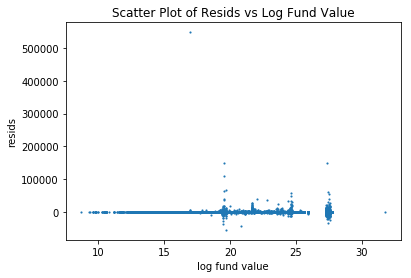

In [73]:
pl.scatter(X.log_value_fund_lag_1, delta_1, s=1.25);
pl.title('Scatter Plot of Resids vs Log Fund Value');
pl.xlabel('log fund value');
pl.ylabel('resids');

Как можно увидеть, никакой зависимости нет, дисперсия примерно везде одинакова. Она заметно выше в точках границ весовых категорий, но мне кажется, это из-за того, что в этих диапазонах просто больше наблюдений, поэтому разброс чуть повыше.

На графике видно, что остатки какие-то выдающиеся. Посмотрю на гистограмме, есть ли у меня такие наблюдения.

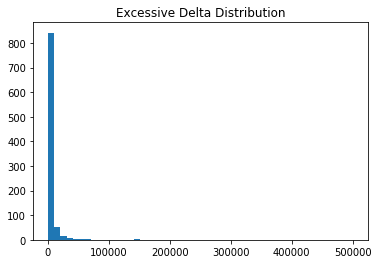

In [75]:
pl.hist(delta_1, bins=50, range=(1000, 500000));
pl.title('Excessive Delta Distribution');

Да, есть много наблюдений, где оценка отличается больше, чем на 1000 процентнов. Вероятно, это из-за того, что в нашей выборке много около-бедных фондов, которые при начале инвестирования в тикер быстро наращивают вложения. При этом, из-за своих возможностей они не могут покупать много акций, из-за чего при постепенном увеличении вложений процентное изменение оказывается невероятно высоким. Это проблема масштаба, как проблема сходимости экономического роста в неразвитых и развитых странах.

Чтобы избавиться от этой проблемы, я нормализую зависимую переменную. Посмотрим, станет ли лучше.

### Модель 2

In [76]:
y = (y - y.mean()) / y.std()

In [77]:
model_2 = sm.OLS(y, X).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     6440.
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        00:17:48   Log-Likelihood:            -1.8350e+06
No. Observations:             1344781   AIC:                         3.670e+06
Df Residuals:                 1344756   BIC:                         3.670e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0067      0.013      0.518      0.604      -0.019       0.032
log_value_fund_lag_1     -0.0020      0.001     -3.187      0.001      -0.003      -0.001
net_shares_lag_1       6.829e-05   8.95e-07     76.291      0.000    6.65e-05       7e-05
amend_1                  -0.0056      0.009     -0.619      0.536      -0.023       0.012
net_shares_lag_2          0.0010      3e-06    341.412      0.000       0.001       0.001
amend_2                  -0.0089      0.010     -0.929      0.353      -0.028       0.010
net_shares_lag_3       2.864e-05   2.39e-06     11.986      0.000     2.4e-05    3.33e-05
amend_3                  -0.0044      0.009     -0.477      0.633      -0.022       0.014
net_shares_lag_4       4.141e-05   2.53e-06     16.341      0.000    3.64e-05    4.64e-05
amend_4                  -0.0053      0.009     -0.615      0.538      -0.022       0.012
turnover                  0.0542      0.008      7.162      0.000       0.039       0.069
hhi                       0.1589      0.031      5.076      0.000       0.098       0.220
hhi_eq_1                 -0.0994      0.061     -1.630      0.103      -0.219       0.020
high_turnover             0.0087      0.005      1.823      0.068      -0.001       0.018
high_hhi                 -0.0478      0.012     -3.950      0.000      -0.072      -0.024
extreme_turnover         -0.1676      0.027     -6.306      0.000      -0.220      -0.116
cluster_hhi              -0.0051      0.003     -1.655      0.098      -0.011       0.001
cluster_turnover          0.0016      0.002      0.698      0.485      -0.003       0.006
sqrt_pos_count_lag_1      0.0004   9.62e-05      4.559      0.000       0.000       0.001
high_pos_count           -0.0141      0.013     -1.125      0.261      -0.039       0.010
extreme_pos_count         0.0110      0.014      0.794      0.427      -0.016       0.038
cluster_size_pos          0.0003      0.003      0.091      0.928      -0.006       0.006
cluster_pos_hhi          -0.0009      0.003     -0.331      0.740      -0.006       0.004
cluster_pos_tvr           0.0064      0.005      1.319      0.187      -0.003       0.016
mean_net_shares_lag_1 -1.039e-06   7.82e-06     -0.133      0.894   -1.64e-05    1.43e-05
=================================================================================
Omnibus:                  9111862.439   Durbin-Watson:                      2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   21958336454245080.000
Skew:                         684.911   Prob(JB):                            0.00
Kurtosis:                  626009.030   Cond. No.                        7.09e+04
=================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the

Коэффициенты стали стабильнее и уравнялись в масштабе. Более того, коэффициент при константе более осмысленный. Можно сказать, что по умолчанию фонды постепенно наращивают вложения в тикеры, но говорить об этом стоит с осторожностью. Наверно, это может происходить, так как стратегии медленнее себя реализуют, чем появляются. Поэтому инвесторы чаще входят в тикеры, чем выходят из них.

In [78]:
# Искомая переменная по второй модели
delta_2 = y - model_2.predict(X)

Если мы посмотрим на экстремальные значения остатков (наблюдений), то заметим, что их стало поменьше, и их экстремальность уменьшилась. Это, несомненно, лучше.

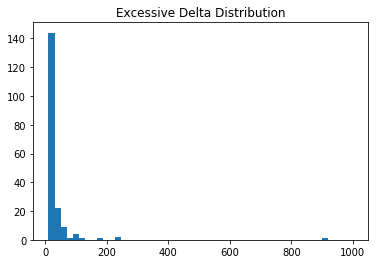

In [79]:
pl.hist(delta_2, bins=50, range=(10, 1000));
pl.title('Excessive Delta Distribution');

На волне успеха попробую нормализовать регрессоры.

### Модель 3

In [80]:
X.iloc[:, 1:-2] = (X.iloc[:, 1:-2] - X.iloc[:, 1:-2].mean()) / X.iloc[:, 1:-2].std()
X.iloc[:, -1] = (X.iloc[:, -1] - X.iloc[:, -1].mean()) / X.iloc[:, -1].std()

In [81]:
model_3 = sm.OLS(y, X).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     6440.
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        00:20:15   Log-Likelihood:            -1.8350e+06
No. Observations:             1344781   AIC:                         3.670e+06
Df Residuals:                 1344756   BIC:                         3.670e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0061      0.005     -1.299      0.194      -0.015       0.003
log_value_fund_lag_1     -0.0046      0.001     -3.187      0.001      -0.007      -0.002
net_shares_lag_1          0.0635      0.001     76.291      0.000       0.062       0.065
amend_1                  -0.0006      0.001     -0.619      0.536      -0.002       0.001
net_shares_lag_2          0.2968      0.001    341.412      0.000       0.295       0.298
amend_2                  -0.0009      0.001     -0.929      0.353      -0.003       0.001
net_shares_lag_3          0.0104      0.001     11.986      0.000       0.009       0.012
amend_3                  -0.0005      0.001     -0.477      0.633      -0.002       0.001
net_shares_lag_4          0.0138      0.001     16.341      0.000       0.012       0.015
amend_4                  -0.0006      0.001     -0.615      0.538      -0.003       0.001
turnover                  0.0099      0.001      7.162      0.000       0.007       0.013
hhi                       0.0084      0.002      5.076      0.000       0.005       0.012
hhi_eq_1                 -0.0014      0.001     -1.630      0.103      -0.003       0.000
high_turnover             0.0023      0.001      1.823      0.068      -0.000       0.005
high_hhi                 -0.0057      0.001     -3.950      0.000      -0.009      -0.003
extreme_turnover         -0.0058      0.001     -6.306      0.000      -0.008      -0.004
cluster_hhi              -0.0016      0.001     -1.655      0.098      -0.003       0.000
cluster_turnover          0.0007      0.001      0.698      0.485      -0.001       0.003
sqrt_pos_count_lag_1      0.0100      0.002      4.559      0.000       0.006       0.014
high_pos_count           -0.0020      0.002     -1.125      0.261      -0.006       0.002
extreme_pos_count         0.0013      0.002      0.794      0.427      -0.002       0.005
cluster_size_pos          0.0001      0.001      0.091      0.928      -0.003       0.003
cluster_pos_hhi          -0.0003      0.001     -0.331      0.740      -0.002       0.002
cluster_pos_tvr           0.0064      0.005      1.319      0.187      -0.003       0.016
mean_net_shares_lag_1    -0.0001      0.001     -0.133      0.894      -0.002       0.001
=================================================================================
Omnibus:                  9111862.439   Durbin-Watson:                      2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   21958336454245112.000
Skew:                         684.911   Prob(JB):                            0.00
Kurtosis:                  626009.030   Cond. No.                            15.7
=================================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the

Ничего не изменилось, только константа стала чуть более значимой. Лучше не стало, поэтому так делать не буду.

Теперь добавлю переменные доли тикера в активах фонда, чтобы посмотреть, как это повлияет на регрессию.

### Модель 4

In [82]:
y = final_df['net_shares']
y = (y - y.mean()) / y.std()

X = final_df[['log_value_fund_lag_1',
        'net_shares_lag_1', 'amend_1', 'net_shares_lag_2', 'amend_2', 
        'net_shares_lag_3', 'amend_3', 'net_shares_lag_4', 'amend_4',
        'ticket_share_lag_1', 'ticket_share_lag_2', 'ticket_share_lag_3', 'ticket_share_lag_4',
        'turnover', 'hhi', 'hhi_eq_1', 'high_turnover', 'high_hhi', 
        'extreme_turnover', 'cluster_hhi', 'cluster_turnover',
        'sqrt_pos_count_lag_1', 'high_pos_count', 'extreme_pos_count',
        'cluster_size_pos', 'cluster_pos_hhi', 'cluster_pos_tvr', 'mean_net_shares_lag_1']].astype('float64')
X = sm.add_constant(X)

In [83]:
model_4 = sm.OLS(y, X).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     5520.
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        00:21:48   Log-Likelihood:            -1.8350e+06
No. Observations:             1344781   AIC:                         3.670e+06
Df Residuals:                 1344752   BIC:                         3.670e+06
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0081      0.013      0.625      0.532      -0.017       0.034
log_value_fund_lag_1     -0.0020      0.001     -3.168      0.002      -0.003      -0.001
net_shares_lag_1       6.829e-05   8.95e-07     76.287      0.000    6.65e-05       7e-05
amend_1                  -0.0058      0.009     -0.636      0.525      -0.024       0.012
net_shares_lag_2          0.0010      3e-06    341.414      0.000       0.001       0.001
amend_2                  -0.0088      0.010     -0.914      0.360      -0.028       0.010
net_shares_lag_3       2.863e-05   2.39e-06     11.981      0.000    2.39e-05    3.33e-05
amend_3                  -0.0045      0.009     -0.485      0.628      -0.022       0.014
net_shares_lag_4       4.141e-05   2.53e-06     16.341      0.000    3.64e-05    4.64e-05
amend_4                  -0.0053      0.009     -0.616      0.538      -0.022       0.012
ticket_share_lag_1        0.1269      0.082      1.557      0.120      -0.033       0.287
ticket_share_lag_2       -0.1878      0.098     -1.925      0.054      -0.379       0.003
ticket_share_lag_3        0.0544      0.098      0.555      0.579      -0.138       0.247
ticket_share_lag_4       -0.0255      0.079     -0.322      0.748      -0.181       0.130
turnover                  0.0543      0.008      7.179      0.000       0.039       0.069
hhi                       0.1632      0.032      5.130      0.000       0.101       0.226
hhi_eq_1                 -0.0827      0.067     -1.228      0.219      -0.215       0.049
high_turnover             0.0087      0.005      1.825      0.068      -0.001       0.018
high_hhi                 -0.0480      0.012     -3.964      0.000      -0.072      -0.024
extreme_turnover         -0.1679      0.027     -6.311      0.000      -0.220      -0.116
cluster_hhi              -0.0052      0.003     -1.665      0.096      -0.011       0.001
cluster_turnover          0.0016      0.002      0.712      0.476      -0.003       0.006
sqrt_pos_count_lag_1      0.0004   9.63e-05      4.504      0.000       0.000       0.001
high_pos_count           -0.0138      0.013     -1.104      0.270      -0.038       0.011
extreme_pos_count         0.0112      0.014      0.807      0.420      -0.016       0.038
cluster_size_pos          0.0002      0.003      0.063      0.950      -0.006       0.006
cluster_pos_hhi          -0.0011      0.003     -0.416      0.678      -0.006       0.004
cluster_pos_tvr           0.0051      0.005      1.011      0.312      -0.005       0.015
mean_net_shares_lag_1 -1.039e-06   7.82e-06     -0.133      0.894   -1.64e-05    1.43e-05
=================================================================================
Omnibus:                  9111867.132   Durbin-Watson:                      2.054
Prob(Omnibus):                  0.000  

Старые коэффициенты лучше и значимее не стали, а некоторые из новых оказались значительно незначимыми. Значимая зависимость только от первых двух лагов доли. Заметим также разнородный характер зависимости. Первый и третий лаг положительно влияют на зависимую переменную, когда второй и четвертый отрицательно. Это может быть связано с тем, что у инвесторов отчетные периоды каждые полгода, а к этому времени они формируют более диверсифицированное портфолио, чтобы привлечь больше инвесторов, поэтому меняют веса активов в противоположные стороны, чтобы быть более ликвидными. Вследствие такого объяснения у меня пропадает необходимость в 3-м и 4-м лаге для доли, так как дополнительного смысла они не несут.

Заметим, что теперь у коэффициента при среднем по фондам почти нулевое отклонение, что что делает его равносильным константе, из-за чего может возникать мультиколлинеарность.

Теперь заменю переменные на их факторизированные аналоги. Должно стать лучше!

### Модель 5

In [84]:
y = final_df['net_shares']
y = (y - y.mean()) / y.std()

X = final_df[['log_value_fund_lag_1', 'high_value_lag_1', 'med_value_lag_1',
        'net_shares_lag_1_low', 'net_shares_lag_1_med', 'net_shares_lag_1_high',
        'net_shares_lag_2_low', 'net_shares_lag_2_med', 'net_shares_lag_2_high',
        'net_shares_lag_3_low', 'net_shares_lag_3_med', 'net_shares_lag_3_high',
        'net_shares_lag_4_low', 'net_shares_lag_4_med', 'net_shares_lag_4_high',
        'ticket_share_lag_1_high', 'ticket_share_lag_1_med', 'ticket_share_lag_1_low',
        'ticket_share_lag_2_high', 'ticket_share_lag_2_med', 'ticket_share_lag_2_low',
        'amend_1', 'amend_2', 'amend_3', 'amend_4',
        'turnover_high', 'turnover_med', 'turnover_low',
        'hhi_high', 'hhi_med', 'hhi_low', 'hhi_eq_1', 'high_turnover', 'high_hhi', 
        'extreme_turnover', 'cluster_hhi', 'cluster_turnover',
        'sqrt_pos_count_lag_1', 'high_pos_count', 'extreme_pos_count',
        'cluster_size_pos', 'cluster_pos_hhi', 'cluster_pos_tvr', 'mean_net_shares_lag_1',
        'mean_net_shares_lag_1_by_value']].astype('float64')
X = sm.add_constant(X)

In [85]:
model_5 = sm.OLS(y, X).fit()
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     5114.
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        00:22:54   Log-Likelihood:            -1.8219e+06
No. Observations:             1344781   AIC:                         3.644e+06
Df Residuals:                 1344744   BIC:                         3.644e+06
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0526      0.015      3.396      0.001       0.022       0.083
log_value_fund_lag_1              -0.0035      0.001     -3.773      0.000      -0.005      -0.002
high_value_lag_1                  -0.0087      0.006     -1.477      0.140      -0.020       0.003
med_value_lag_1                   -0.0083      0.005     -1.667      0.096      -0.018       0.001
net_shares_lag_1_low               0.0007   6.37e-05     11.393      0.000       0.001       0.001
net_shares_lag_1_med               0.0003   6.91e-06     44.209      0.000       0.000       0.000
net_shares_lag_1_high           2.909e-05   4.45e-07     65.384      0.000    2.82e-05       3e-05
net_shares_lag_2_low            2.633e-05   8.57e-05      0.307      0.759      -0.000       0.000
net_shares_lag_2_med            4.337e-05   4.23e-06     10.256      0.000    3.51e-05    5.17e-05
net_shares_lag_2_high              0.0006   1.62e-06    348.747      0.000       0.001       0.001
net_shares_lag_3_low            -4.96e-05      0.000     -0.367      0.714      -0.000       0.000
net_shares_lag_3_med            3.164e-05   3.06e-06     10.350      0.000    2.57e-05    3.76e-05
net_shares_lag_3_high              0.0003   4.28e-06     73.094      0.000       0.000       0.000
net_shares_lag_4_low               0.0004      0.000      2.277      0.023    5.52e-05       0.001
net_shares_lag_4_med           -1.991e-06   2.87e-06     -0.693      0.489   -7.62e-06    3.64e-06
net_shares_lag_4_high              0.0002   5.79e-06     41.276      0.000       0.000       0.000
ticket_share_lag_1_high         2.909e-05   4.45e-07     65.384      0.000    2.82e-05       3e-05
ticket_share_lag_1_med             0.0003   6.91e-06     44.209      0.000       0.000       0.000
ticket_share_lag_1_low             0.0007   6.37e-05     11.393      0.000       0.001       0.001
ticket_share_lag_2_high            0.0006   1.62e-06    348.747      0.000       0.001       0.001
ticket_share_lag_2_med          4.337e-05   4.23e-06     10.256      0.000    3.51e-05    5.17e-05
ticket_share_lag_2_low          2.633e-05   8.57e-05      0.307      0.759      -0.000       0.000
amend_1                           -0.0059      0.009     -0.659      0.510      -0.024       0.012
amend_2                           -0.0065      0.009     -0.689      0.491      -0.025       0.012
amend_3                           -0.0063      0.009     -0.690      0.490      -0.024       0.012
amend_4                           -0.0075      0.009     -0.872      0.383      -0.024       0.009
turnover_high                      0.0274      0.004      7.048      0.000       0.020       0.035
turnover_med                       0.0134      0.007      1.990      0.047       0.000       0.027
turnover_low  

Эти переменные хорошо повлияли на модель. Они сами значимые, и теперь значима и константа!

Опять замечу, что у коэффициента при среднем по схожим фондам такие же проблемы с похожестью на константу.

Если смотреть глубже, то можно заметить, что незначимы почти все коэффициенты для малой весовой категории. Вероятно, на низкой ценности стратегии инвестирования своеобразны и независят от предыдущих тенденций.

Кроме того, изменение не зависит от среднего изменения по фондам схожей весовой категории. <i>Размер не имеет значения?</i>
Ещё интересно, что индикатор средней категории тоже часто не значим. Вероятно, единственное уместное деление - на большие и маленькие фонды, без средних.

Значимость факторизации проявляется в том, что масштабы всех коэффициентов в разы (!!!) уменьшились.

# Макро-параметры

Я предполагаю, что инвесторы обращают внимание на макроэкономическую ситуацию и её изменение <i>(иначе зачем макроэкономику преподают и изучают)</i>, чтобы исправлять свои стратегии.

<b> Поэтому я считаю, что важно проконтролировать изменение макроэкономических параметров в модели, так как без этого их влияние войдет в остаток, а я хочу, чтобы в остатках лежало только настроение фонда относительно тикера, определяемое его новыми инсайтами, а не экзогенными факторами. </b>

Я буду пользоваться парсером pandas, чтобы получать данные из статистической службы FRED.

В качестве переменных я собираюсь использовать поквартальное изменение ключевой ставки, ставки по десятилетним казначейским облигациям, уровню инфляции и росту ВВП (последние два тоже поквартальные).

In [86]:
import pandas_datareader as wb

In [102]:
# скачиваю ставки и нахожу их изменение, группируя по кварталам
rates = wb.DataReader(['DGS10', 'DFF', 'UNRATE'], 'fred', start=2012).resample('Q-DEC').mean().diff() / 100
rates.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
rates.DATE = rates.DATE.dt.to_period('Q')

In [103]:
# Нахожу инфлцяцию через Индекс потребительских цен, группируя по кварталам
inflation = wb.DataReader('CPIAUCSL', 'fred', start=2012).resample('Q-DEC').mean().pct_change()
inflation.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
inflation.DATE = inflation.DATE.dt.to_period('Q')

In [104]:
# Скачиваю данные по ВВП и считаю рост (а тут сразу всё поквартально!)
gdp_growth = wb.DataReader('GDP', 'fred', start=2012).pct_change()
gdp_growth.reset_index(inplace=True)
# Перевожу индекс в нужные единицы измерения
gdp_growth.DATE = gdp_growth.DATE.dt.to_period('Q')

In [120]:
%%time

# Связываю полученные значения с нашим датасетом

final_df = final_df.merge(rates, left_on='period', right_on='DATE', how='left', suffixes=(False, False))
final_df = final_df.merge(inflation, on="DATE", how='left', suffixes=(False, False))
final_df = final_df.merge(gdp_growth, on="DATE", how='left', suffixes=(False, False))
final_df.drop('DATE', axis=1, inplace=True)

Wall time: 11.5 s


Теперь построим модель с макроиндикаторами!

### Модель 6

In [121]:
y = final_df['net_shares']
y = (y - y.mean()) / y.std()

X = final_df[['log_value_fund_lag_1', 'high_value_lag_1', 'med_value_lag_1',
        'net_shares_lag_1_low', 'net_shares_lag_1_med', 'net_shares_lag_1_high',
        'net_shares_lag_2_low', 'net_shares_lag_2_med', 'net_shares_lag_2_high',
        'net_shares_lag_3_low', 'net_shares_lag_3_med', 'net_shares_lag_3_high',
        'net_shares_lag_4_low', 'net_shares_lag_4_med', 'net_shares_lag_4_high',
        'ticket_share_lag_1_high', 'ticket_share_lag_1_med', 'ticket_share_lag_1_low',
        'ticket_share_lag_2_high', 'ticket_share_lag_2_med', 'ticket_share_lag_2_low',
        'amend_1', 'amend_2', 'amend_3', 'amend_4',
        'turnover_high', 'turnover_med', 'turnover_low',
        'hhi_high', 'hhi_med', 'hhi_low', 'hhi_eq_1', 'high_turnover', 'high_hhi', 
        'extreme_turnover', 'cluster_hhi', 'cluster_turnover',
        'sqrt_pos_count_lag_1', 'high_pos_count', 'extreme_pos_count',
        'cluster_size_pos', 'cluster_pos_hhi', 'cluster_pos_tvr', 'mean_net_shares_lag_1',
        'mean_net_shares_lag_1_by_value',
         'DGS10', 'DFF', 'UNRATE', 'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [122]:
model_6 = sm.OLS(y, X).fit()
model_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     4491.
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        00:56:14   Log-Likelihood:            -1.8219e+06
No. Observations:             1344781   AIC:                         3.644e+06
Df Residuals:                 1344739   BIC:                         3.644e+06
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0073      0.018      0.397      0.692      -0.029       0.044
log_value_fund_lag_1              -0.0037      0.001     -3.971      0.000      -0.005      -0.002
high_value_lag_1                  -0.0077      0.006     -1.303      0.193      -0.019       0.004
med_value_lag_1                   -0.0079      0.005     -1.590      0.112      -0.018       0.002
net_shares_lag_1_low               0.0007   6.37e-05     11.418      0.000       0.001       0.001
net_shares_lag_1_med               0.0003   6.91e-06     44.216      0.000       0.000       0.000
net_shares_lag_1_high           2.908e-05   4.45e-07     65.375      0.000    2.82e-05       3e-05
net_shares_lag_2_low            2.615e-05   8.57e-05      0.305      0.760      -0.000       0.000
net_shares_lag_2_med            4.336e-05   4.23e-06     10.255      0.000    3.51e-05    5.17e-05
net_shares_lag_2_high              0.0006   1.62e-06    348.751      0.000       0.001       0.001
net_shares_lag_3_low           -4.675e-05      0.000     -0.346      0.729      -0.000       0.000
net_shares_lag_3_med            3.165e-05   3.06e-06     10.352      0.000    2.57e-05    3.76e-05
net_shares_lag_3_high              0.0003   4.28e-06     73.093      0.000       0.000       0.000
net_shares_lag_4_low               0.0004      0.000      2.278      0.023    5.54e-05       0.001
net_shares_lag_4_med           -1.966e-06   2.87e-06     -0.684      0.494    -7.6e-06    3.67e-06
net_shares_lag_4_high              0.0002   5.79e-06     41.281      0.000       0.000       0.000
ticket_share_lag_1_high         2.908e-05   4.45e-07     65.375      0.000    2.82e-05       3e-05
ticket_share_lag_1_med             0.0003   6.91e-06     44.216      0.000       0.000       0.000
ticket_share_lag_1_low             0.0007   6.37e-05     11.418      0.000       0.001       0.001
ticket_share_lag_2_high            0.0006   1.62e-06    348.751      0.000       0.001       0.001
ticket_share_lag_2_med          4.336e-05   4.23e-06     10.255      0.000    3.51e-05    5.17e-05
ticket_share_lag_2_low          2.615e-05   8.57e-05      0.305      0.760      -0.000       0.000
amend_1                           -0.0077      0.009     -0.857      0.392      -0.025       0.010
amend_2                           -0.0069      0.009     -0.732      0.464      -0.026       0.012
amend_3                           -0.0054      0.009     -0.592      0.554      -0.023       0.012
amend_4                           -0.0056      0.009     -0.647      0.518      -0.022       0.011
turnover_high                      0.0255      0.004      6.523      0.000       0.018       0.033
turnover_med                       0.0119      0.007      1.766      0.077      -0.001       0.025
turnover_low  

Все индикаторы, кроме ставки по облигациям, оказались значимыми.

Наблюдается отрицательная зависимость от безработицы, положительная от инфляции и отрицательная от роста ВВП.
Первая зависимость интиутивно понятно. Низкая безработица свидетельствует о росте экономики, который наблюдается последнее время, а во время роста увеличиваются вложения в финансовые активы. Если рост вызван увеличением предложения, то ещё более очевидно, что улучшение ситуации у эмитентов делает их более привлекательным.

Вторая и третья зависимость не так очевидна, но у меня есть объяснение. Увеличение инфляции и падение выпуска происходит при уменьшении совокупного предложения. Это говорит об ухудшении положении эмитентов. Тем не менее, стоит вспомнить про то, что бизнес-циклы неотъемлемая часть экономики. И в такой ситуации очевидно наблюдается спад. Мы знаем, как и все, что после спада наступает рост. А во время роста (см. абзац выше) увеличивается спрос на финансовые активы и, как следствие, цена на них. Значит, инвестор может купить акции сейчас дешевле и продать их во время бума подороже. Наверно, так можно объяснить эти коэффициенты.

Положительная зависимость от ключевой ставки объясняется тем, что увеличение ставки может быть представлено как контр-мера против перегревания экономики во время экономического бума, а поведение во время бума я уже описывал.

Если надо, то я могу воспользоваться IS-LM моделью, чтобы более подробно попытаться объяснить зависимость и логику.

Давайте для интереса посмотрим, какие переменные отвечают за мультиколлинеарность.

In [93]:
%%time

from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = model_7.model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]

vif_series = pd.Series(index=X.columns, data=vif)
vif_series[vif_series >= 10].index.values

Wall time: 8min 43s


array(['const', 'net_shares_lag_1_low', 'net_shares_lag_1_med',
       'net_shares_lag_1_high', 'net_shares_lag_2_low',
       'net_shares_lag_2_med', 'net_shares_lag_2_high',
       'ticket_share_lag_1_high', 'ticket_share_lag_1_med',
       'ticket_share_lag_1_low', 'ticket_share_lag_2_high',
       'ticket_share_lag_2_med', 'ticket_share_lag_2_low',
       'turnover_high', 'turnover_med', 'turnover_low', 'hhi_high',
       'hhi_med', 'hhi_low', 'CPIAUCSL'], dtype=object)

Мы видим тут константу (она коррелирует со средним по фондам и средним по схожим фондам), индикаторы размера, так как они сильно коррелируют с другими факторизованными переменными, переменные, связанные с turnover и HHI, так как они связаны сильно с лагами и доходом соотвественно, а также похожи на константу в силу маленькой дисперсии, и инфляцию, так как она связана со всеми макро показателями.

Кроме того, высокая мультиколлинеарность у переменных чистого изменения и доли акций. Мне кажется, они связаны, так как высокое изменение числа акций ведет к большей доле.

## Мы не можем жить без ~~космоса~~ факторизации

Предположу, что фонд будет по-разному реагировать на изменение макроэкономического положения в зависимости от своего размера. Поэтому факторизую индикаторы и построю на новых переменных регрессию.

In [123]:
for macro_factor in ['DGS10', 'DFF', 'UNRATE', 'CPIAUCSL', 'GDP']:
    final_df[macro_factor + '_high'] = final_df[macro_factor].mul(final_df.high_value, axis=0)
    final_df[macro_factor + '_med'] = final_df[macro_factor].mul(final_df.med_value, axis=0)
    final_df[macro_factor + '_low'] = final_df[macro_factor].mul(final_df.low_value, axis=0)

### Модель 7

In [124]:
y = final_df['net_shares']
y = (y - y.mean()) / y.std()

X = final_df[['log_value_fund_lag_1', 'high_value_lag_1', 'med_value_lag_1',
        'net_shares_lag_1_low', 'net_shares_lag_1_med', 'net_shares_lag_1_high',
        'net_shares_lag_2_low', 'net_shares_lag_2_med', 'net_shares_lag_2_high',
        'net_shares_lag_3_low', 'net_shares_lag_3_med', 'net_shares_lag_3_high',
        'net_shares_lag_4_low', 'net_shares_lag_4_med', 'net_shares_lag_4_high',
        'ticket_share_lag_1_high', 'ticket_share_lag_1_med', 'ticket_share_lag_1_low',
        'ticket_share_lag_2_high', 'ticket_share_lag_2_med', 'ticket_share_lag_2_low',
        'amend_1', 'amend_2', 'amend_3', 'amend_4',
        'turnover_high', 'turnover_med', 'turnover_low',
        'hhi_high', 'hhi_med', 'hhi_low', 'hhi_eq_1', 'high_turnover', 'high_hhi', 
        'extreme_turnover', 'cluster_hhi', 'cluster_turnover',
        'sqrt_pos_count_lag_1', 'high_pos_count', 'extreme_pos_count',
        'cluster_size_pos', 'cluster_pos_hhi', 'cluster_pos_tvr', 'mean_net_shares_lag_1',
        'mean_net_shares_lag_1_by_value',
        'DGS10_high', 'DGS10_med', 'DGS10_low', 'DFF_high', 'DFF_med', 'DFF_low', 'UNRATE_high',
        'UNRATE_med', 'UNRATE_low', 'CPIAUCSL_high', 'CPIAUCSL_med',
        'CPIAUCSL_low', 'GDP_high', 'GDP_med', 'GDP_low']].astype('float64')
X = sm.add_constant(X)

In [125]:
model_7 = sm.OLS(y, X).fit()
model_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     3612.
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        00:56:34   Log-Likelihood:            -1.8218e+06
No. Observations:             1344781   AIC:                         3.644e+06
Df Residuals:                 1344729   BIC:                         3.644e+06
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0842      0.021      4.059      0.000       0.044       0.125
log_value_fund_lag_1              -0.0053      0.001     -5.634      0.000      -0.007      -0.003
high_value_lag_1                  -0.0650      0.009     -7.198      0.000      -0.083      -0.047
med_value_lag_1                   -0.0404      0.007     -5.463      0.000      -0.055      -0.026
net_shares_lag_1_low               0.0007   6.37e-05     11.418      0.000       0.001       0.001
net_shares_lag_1_med               0.0003   6.91e-06     44.245      0.000       0.000       0.000
net_shares_lag_1_high           2.908e-05   4.45e-07     65.372      0.000    2.82e-05       3e-05
net_shares_lag_2_low            3.009e-05   8.57e-05      0.351      0.726      -0.000       0.000
net_shares_lag_2_med            4.346e-05   4.23e-06     10.280      0.000    3.52e-05    5.18e-05
net_shares_lag_2_high              0.0006   1.62e-06    348.763      0.000       0.001       0.001
net_shares_lag_3_low           -4.329e-05      0.000     -0.320      0.749      -0.000       0.000
net_shares_lag_3_med             3.17e-05   3.06e-06     10.370      0.000    2.57e-05    3.77e-05
net_shares_lag_3_high              0.0003   4.28e-06     73.086      0.000       0.000       0.000
net_shares_lag_4_low               0.0004      0.000      2.310      0.021     6.1e-05       0.001
net_shares_lag_4_med           -1.984e-06   2.87e-06     -0.690      0.490   -7.62e-06    3.65e-06
net_shares_lag_4_high              0.0002   5.79e-06     41.273      0.000       0.000       0.000
ticket_share_lag_1_high         2.908e-05   4.45e-07     65.372      0.000    2.82e-05       3e-05
ticket_share_lag_1_med             0.0003   6.91e-06     44.245      0.000       0.000       0.000
ticket_share_lag_1_low             0.0007   6.37e-05     11.418      0.000       0.001       0.001
ticket_share_lag_2_high            0.0006   1.62e-06    348.763      0.000       0.001       0.001
ticket_share_lag_2_med          4.346e-05   4.23e-06     10.280      0.000    3.52e-05    5.18e-05
ticket_share_lag_2_low          3.009e-05   8.57e-05      0.351      0.726      -0.000       0.000
amend_1                           -0.0035      0.009     -0.381      0.703      -0.021       0.014
amend_2                           -0.0087      0.010     -0.912      0.362      -0.027       0.010
amend_3                           -0.0063      0.009     -0.690      0.490      -0.024       0.012
amend_4                           -0.0046      0.009     -0.534      0.594      -0.021       0.012
turnover_high                      0.0202      0.004      5.082      0.000       0.012       0.028
turnover_med                       0.0130      0.008      1.717      0.086      -0.002       0.028
turnover_low  

Из модели можно заметить, что индикаторы значимо влияют только на большие фонды и иногда на средние (как ключевая ставка, которая оказалась более универсальной).

Вероятно, маленькие фонды не думают о глобальном. Кроме того, направленность эффекта от макроиндикаторов у них противоположная в отличие от средних и больших фондов. В любом случае, это, наверно, объясняется спецификой больших фондов, которая обсуждалась в этой работе и требует ещё более тщательного анализа.

Заметим, что несмотря на свою красоту эта модель, как и предыдущие, имеет маленький R^2, то есть, имеет маленькую предсказательную способность и мало объясняет дисперсию изменения.
Но мы уже видели, что дисперсия так рознится из-за проблемы с малыми фондами и проблемы масштаба.

Главное, что наша модель имеет <b>прикладной и экономический смысл</b>!

## Баллада о ставке

Мне показалось странным, что ставка по облигациям незначима для предсказания чистого изменения. Возможно, проблема в том, что нам надо учитывать не её изменение, а её абсолютное значение. Сейчас я проверю данное предположение.

In [126]:
# удаляю столбец с данными об изменении ставки
final_df.drop('DGS10', axis=1, inplace=True)

# скачиваю и преобразую данные по ставке к нужному виду
treas_10yr = wb.DataReader('DGS10', 'fred', start=2012).resample('Q-DEC').mean() / 100
treas_10yr.reset_index(inplace=True)
treas_10yr.DATE = treas_10yr.DATE.dt.to_period('Q')

# Свожу данные с датасетом
final_df = final_df.merge(treas_10yr, left_on='period', right_on='DATE', how='left', suffixes=(False, False))
final_df.drop('DATE', axis=1, inplace=True)

Построим регрессию на новых данных.

### Модель 8

In [129]:
y = final_df['net_shares']
y = (y - y.mean()) / y.std()

X = final_df[['log_value_fund_lag_1', 'high_value_lag_1', 'med_value_lag_1',
        'net_shares_lag_1_low', 'net_shares_lag_1_med', 'net_shares_lag_1_high',
        'net_shares_lag_2_low', 'net_shares_lag_2_med', 'net_shares_lag_2_high',
        'net_shares_lag_3_low', 'net_shares_lag_3_med', 'net_shares_lag_3_high',
        'net_shares_lag_4_low', 'net_shares_lag_4_med', 'net_shares_lag_4_high',
        'ticket_share_lag_1_high', 'ticket_share_lag_1_med', 'ticket_share_lag_1_low',
        'ticket_share_lag_2_high', 'ticket_share_lag_2_med', 'ticket_share_lag_2_low',
        'amend_1', 'amend_2', 'amend_3', 'amend_4',
        'turnover_high', 'turnover_med', 'turnover_low',
        'hhi_high', 'hhi_med', 'hhi_low', 'hhi_eq_1', 'high_turnover', 'high_hhi', 
        'extreme_turnover', 'cluster_hhi', 'cluster_turnover',
        'sqrt_pos_count_lag_1', 'high_pos_count', 'extreme_pos_count',
        'cluster_size_pos', 'cluster_pos_hhi', 'cluster_pos_tvr', 'mean_net_shares_lag_1',
        'mean_net_shares_lag_1_by_value',
         'DGS10', 'DFF', 'UNRATE', 'CPIAUCSL', 'GDP']].astype('float64')
X = sm.add_constant(X)

In [130]:
model_8 = sm.OLS(y, X).fit()
model_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     4494.
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        00:58:01   Log-Likelihood:            -1.8218e+06
No. Observations:             1344781   AIC:                         3.644e+06
Df Residuals:                 1344739   BIC:                         3.644e+06
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.0445      0.017      2.599      0.009       0.011       0.078
log_value_fund_lag_1              -0.0033      0.001     -3.577      0.000      -0.005      -0.001
high_value_lag_1                  -0.0086      0.006     -1.453      0.146      -0.020       0.003
med_value_lag_1                   -0.0078      0.005     -1.570      0.116      -0.018       0.002
net_shares_lag_1_low               0.0007   6.37e-05     11.434      0.000       0.001       0.001
net_shares_lag_1_med               0.0003   6.91e-06     44.210      0.000       0.000       0.000
net_shares_lag_1_high           2.909e-05   4.45e-07     65.391      0.000    2.82e-05       3e-05
net_shares_lag_2_low            2.599e-05   8.57e-05      0.303      0.762      -0.000       0.000
net_shares_lag_2_med            4.333e-05   4.23e-06     10.249      0.000     3.5e-05    5.16e-05
net_shares_lag_2_high              0.0006   1.62e-06    348.760      0.000       0.001       0.001
net_shares_lag_3_low            -4.83e-05      0.000     -0.358      0.721      -0.000       0.000
net_shares_lag_3_med            3.161e-05   3.06e-06     10.342      0.000    2.56e-05    3.76e-05
net_shares_lag_3_high              0.0003   4.28e-06     73.100      0.000       0.000       0.000
net_shares_lag_4_low               0.0004      0.000      2.288      0.022    5.71e-05       0.001
net_shares_lag_4_med           -1.981e-06   2.87e-06     -0.689      0.491   -7.61e-06    3.65e-06
net_shares_lag_4_high              0.0002   5.79e-06     41.270      0.000       0.000       0.000
ticket_share_lag_1_high         2.909e-05   4.45e-07     65.391      0.000    2.82e-05       3e-05
ticket_share_lag_1_med             0.0003   6.91e-06     44.210      0.000       0.000       0.000
ticket_share_lag_1_low             0.0007   6.37e-05     11.434      0.000       0.001       0.001
ticket_share_lag_2_high            0.0006   1.62e-06    348.760      0.000       0.001       0.001
ticket_share_lag_2_med          4.333e-05   4.23e-06     10.249      0.000     3.5e-05    5.16e-05
ticket_share_lag_2_low          2.599e-05   8.57e-05      0.303      0.762      -0.000       0.000
amend_1                           -0.0078      0.009     -0.860      0.390      -0.025       0.010
amend_2                           -0.0066      0.009     -0.696      0.486      -0.025       0.012
amend_3                           -0.0061      0.009     -0.674      0.501      -0.024       0.012
amend_4                           -0.0076      0.009     -0.886      0.376      -0.024       0.009
turnover_high                      0.0254      0.004      6.490      0.000       0.018       0.033
turnover_med                       0.0114      0.007      1.701      0.089      -0.002       0.025
turnover_low  

Теперь мы видим, что ставка значима. Наконец-то в модели появился здравый смысл. Её знак можно объяснить тем, что при увеличении ставки (безрисковой доходности) привлекательность более рискованных финансовых активов падает, и безрисковые активы начинают их вытеснять.

Теперь посмотрим, как факторизация ставки повлияет на её влияние на модель.

Сначала факторизируем переменную.

In [131]:
for macro_factor in ['DGS10']:
    final_df[macro_factor + '_high'] = final_df[macro_factor].mul(final_df.high_value, axis=0)
    final_df[macro_factor + '_med'] = final_df[macro_factor].mul(final_df.med_value, axis=0)
    final_df[macro_factor + '_low'] = final_df[macro_factor].mul(final_df.low_value, axis=0)

Теперь построим регрессию.

### Модель 9

In [132]:
y = final_df['net_shares']
y = (y - y.mean()) / y.std()

X = final_df[['log_value_fund_lag_1', 'high_value_lag_1', 'med_value_lag_1',
        'net_shares_lag_1_low', 'net_shares_lag_1_med', 'net_shares_lag_1_high',
        'net_shares_lag_2_low', 'net_shares_lag_2_med', 'net_shares_lag_2_high',
        'net_shares_lag_3_low', 'net_shares_lag_3_med', 'net_shares_lag_3_high',
        'net_shares_lag_4_low', 'net_shares_lag_4_med', 'net_shares_lag_4_high',
        'ticket_share_lag_1_high', 'ticket_share_lag_1_med', 'ticket_share_lag_1_low',
        'ticket_share_lag_2_high', 'ticket_share_lag_2_med', 'ticket_share_lag_2_low',
        'amend_1', 'amend_2', 'amend_3', 'amend_4',
        'turnover_high', 'turnover_med', 'turnover_low',
        'hhi_high', 'hhi_med', 'hhi_low', 'hhi_eq_1', 'high_turnover', 'high_hhi', 
        'extreme_turnover', 'cluster_hhi', 'cluster_turnover',
        'sqrt_pos_count_lag_1', 'high_pos_count', 'extreme_pos_count',
        'cluster_size_pos', 'cluster_pos_hhi', 'cluster_pos_tvr', 'mean_net_shares_lag_1',
        'mean_net_shares_lag_1_by_value',
        'DGS10_high', 'DGS10_med', 'DGS10_low', 'DFF_high', 'DFF_med', 'DFF_low', 'UNRATE_high',
        'UNRATE_med', 'UNRATE_low', 'CPIAUCSL_high', 'CPIAUCSL_med',
        'CPIAUCSL_low', 'GDP_high', 'GDP_med', 'GDP_low']].astype('float64')
X = sm.add_constant(X)

In [133]:
model_9 = sm.OLS(y, X).fit()
model_9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             net_shares   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     3615.
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        00:58:30   Log-Likelihood:            -1.8218e+06
No. Observations:             1344781   AIC:                         3.644e+06
Df Residuals:                 1344729   BIC:                         3.644e+06
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.1112      0.019      5.728      0.000       0.073       0.149
log_value_fund_lag_1              -0.0046      0.001     -4.894      0.000      -0.006      -0.003
high_value_lag_1                  -0.0599      0.009     -6.744      0.000      -0.077      -0.043
med_value_lag_1                   -0.0374      0.007     -5.128      0.000      -0.052      -0.023
net_shares_lag_1_low               0.0007   6.37e-05     11.404      0.000       0.001       0.001
net_shares_lag_1_med               0.0003   6.91e-06     44.238      0.000       0.000       0.000
net_shares_lag_1_high           2.909e-05   4.45e-07     65.393      0.000    2.82e-05       3e-05
net_shares_lag_2_low            2.979e-05   8.57e-05      0.348      0.728      -0.000       0.000
net_shares_lag_2_med            4.344e-05   4.23e-06     10.275      0.000    3.52e-05    5.17e-05
net_shares_lag_2_high              0.0006   1.62e-06    348.774      0.000       0.001       0.001
net_shares_lag_3_low           -4.767e-05      0.000     -0.353      0.724      -0.000       0.000
net_shares_lag_3_med            3.168e-05   3.06e-06     10.363      0.000    2.57e-05    3.77e-05
net_shares_lag_3_high              0.0003   4.28e-06     73.095      0.000       0.000       0.000
net_shares_lag_4_low               0.0004      0.000      2.319      0.020    6.25e-05       0.001
net_shares_lag_4_med           -1.999e-06   2.87e-06     -0.695      0.487   -7.63e-06    3.63e-06
net_shares_lag_4_high              0.0002   5.79e-06     41.263      0.000       0.000       0.000
ticket_share_lag_1_high         2.909e-05   4.45e-07     65.393      0.000    2.82e-05       3e-05
ticket_share_lag_1_med             0.0003   6.91e-06     44.238      0.000       0.000       0.000
ticket_share_lag_1_low             0.0007   6.37e-05     11.404      0.000       0.001       0.001
ticket_share_lag_2_high            0.0006   1.62e-06    348.774      0.000       0.001       0.001
ticket_share_lag_2_med          4.344e-05   4.23e-06     10.275      0.000    3.52e-05    5.17e-05
ticket_share_lag_2_low          2.979e-05   8.57e-05      0.348      0.728      -0.000       0.000
amend_1                           -0.0051      0.009     -0.563      0.574      -0.023       0.013
amend_2                           -0.0087      0.009     -0.917      0.359      -0.027       0.010
amend_3                           -0.0075      0.009     -0.827      0.408      -0.025       0.010
amend_4                           -0.0075      0.009     -0.869      0.385      -0.024       0.009
turnover_high                      0.0202      0.004      5.088      0.000       0.012       0.028
turnover_med                       0.0122      0.008      1.614      0.107      -0.003       0.027
turnover_low  

Как и для других макроиндикаторов, ставка оказалась значимой для больших фондов и не очень значимой для остальных.

Заметим также, что в зависимости от размера эффект отличается от предыдущих значений. Рост ВВП при всех размерах теперь влияет отрицательно, а рост инфляции - положительно. Кроме того, увеличился масштаб коэффициентов. Получается, в зависимости от того, берем ли мы разницу ставки или её абсолютное значение, мы получаем две разные модели с разным характером влияния макроиндикаторов. Хотелось бы это объяснить, но хочется для этого лучше понимать специфику инвестирования фондов в разных весовых категориях.

# Сохранение датасета.

Для удобства сохраню полученные результаты.

In [82]:
import pickle

# сохраняю полный датасет
with open('final_df.pkl', 'wb') as f:
    pickle.dump(final_df, f, protocol=-1)

# Планируемая работа

1. Усовершенствовать чистку исходных данных, так как сейчас она примитивна.

    Как минимум, стоит учесть поправки к исходным отчетам, но пока непонятен их характер. Там присутствуют поправки только по активам, которых не было в исходном отчете, или же там есть поправки по активам, которые уже были упомянуты. Можно создать индикатор того, что актив был в поправках, кстати.<br><br>
   
2. Выгрузить названия фондов из EDGAR и через Thomas Reuters сопоставить им их стили инвестирования, через что можно было бы определить схожие фонды. Потом можно было бы вычислить, например, среднее изменение актива по схожим фондам или составить кросс-произведение с другими индикаторами.<br><br>

3. Аналогичная ситуация с акциями. Для них можно получить их индустрию. В сущности, можно тоже вычислить схожие фонды по их выбору индустрий. Также можно добавить фичи принадлежности акции индустрии, указать изменение позиции фонда по индустрии и долю индустрии в фонде. Кроме того, можно посчитать HHI и Turnover не в разрезе акций, а в разрезе индустрий. Можно сделать много новых индикаторов, посмотреть на совместное распределение HHI и Turnover с размером фонда.<br><br>

4. Понять, надо ли оставлять в данных, на которых я буду тренировать бустинги, леса и прочие чудеса, кросс-произведения дохода и других непрерывных переменных или достаточно будет использовать все переменные по отдельности, ведь всех можно применить PolynomialFeatures.<br><br>

5. Понять, как лучше разделять данные на тест и трейн.<br><br>

6. Может, не выкидывать значения, где лагов не хватает, а заменить там всё нулями?

the coursework will return ...